# Pre Process the glider data
#### This notebook performs the following:

1) Loads glider data<br>
2) Subsets to passage crossings<br>
3) Interpolates temperature, salinity, and density onto a regular depth/latitude grid<br>
4) Calculates geostrophic velocity using the gliders depth-averaged current as a constraint<br>
5) Saves output in an xarray NetCDF

## Imports

In [1]:
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seawater as sw
import cmocean.cm as cmo
from scipy import integrate
from scipy.interpolate import griddata
import gsw
import sys
import matplotlib.dates as mdates


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/2552063331.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


## Load glider data

In [2]:
ds_id = 'ru29-20230530T1910-profile-sci-delayed'

## Load flight data
variables = ['depth', 'depth_interpolated','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity', 'oxygen_concentration_shifted','source_file', 'u', 'v']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(gdf.salinity.values, gdf.pressure.values, gdf.longitude.values, gdf.latitude.values)
gdf['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, gdf.potential_temperature.values, gdf.pressure.values)
gdf['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
gdf['sigma0'] = sigma0

gdf

,depth,depth_interpolated,pressure,latitude,longitude,time,potential_temperature,salinity,oxygen_concentration_shifted,source_file,u,v,absolute_salinity,conservative_temperature,sigma0
0,0.005499,0.005499,0.005532,14.548805,-61.108198,2023-05-30T19:13:21.36Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),NaN,NaN,NaN,NaN,NaN
1,0.060494,0.060494,0.060848,14.548813,-61.108200,2023-05-30T19:13:26.26Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),NaN,NaN,NaN,NaN,NaN
2,0.032997,0.032997,0.033190,14.548815,-61.108192,2023-05-30T19:13:31.15Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),NaN,NaN,NaN,NaN,NaN
3,0.087991,0.087991,0.088506,14.548825,-61.108192,2023-05-30T19:13:36.06Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),NaN,NaN,NaN,NaN,NaN
4,0.032997,0.032997,0.033190,14.548822,-61.108192,2023-05-30T19:13:40.96Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686303,1.938635,1.938635,1.950000,14.549099,-61.113260,2023-06-26T18:28:13.50Z,28.937029,35.078087,NaN,ru29-2023-176-0-2-dbd(06760002),NaN,NaN,35.244005,28.941265,1022.144398
1686304,1.660268,1.660268,1.670000,14.549099,-61.113256,2023-06-26T18:28:15.52Z,28.937798,35.078550,NaN,ru29-2023-176-0-2-dbd(06760002),NaN,NaN,35.244470,28.942084,1022.144466
1686305,1.371959,1.371959,1.380000,14.549099,-61.113253,2023-06-26T18:28:17.53Z,28.939667,35.075657,NaN,ru29-2023-176-0-2-dbd(06760002),NaN,NaN,35.241563,28.944150,1022.141646
1686306,NaN,1.237746,NaN,14.549099,-61.113251,2023-06-26T18:28:18.23Z,NaN,NaN,NaN,ru29-2023-176-0-2-dbd(06760002),NaN,NaN,NaN,NaN,NaN


## Load a seperate dataframe for the flight params to get m_water_vx and m_water_vy

In [3]:
ds_id = 'ru29-20230530T1910-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time','source_file', 'm_water_vx', 'm_water_vy']
fgdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
fgdf.columns = variables

fgdf

,depth,latitude,longitude,time,source_file,m_water_vx,m_water_vy
0,0.032997,14.548237,-61.107580,2023-05-30T19:09:57.21Z,ru29-2023-149-3-0-dbd(06730000),0.000034,0.016108
1,0.032997,14.548237,-61.107580,2023-05-30T19:11:00.84Z,ru29-2023-149-3-0-dbd(06730000),0.000034,0.016108
2,NaN,14.548461,-61.107827,2023-05-30T19:11:30.44Z,ru29-2023-149-3-0-dbd(06730000),NaN,NaN
3,NaN,14.548496,-61.107866,2023-05-30T19:11:35.10Z,ru29-2023-149-3-0-dbd(06730000),NaN,NaN
4,NaN,14.548536,-61.107909,2023-05-30T19:11:40.28Z,ru29-2023-149-3-0-dbd(06730000),NaN,NaN
...,...,...,...,...,...,...,...
1721490,NaN,14.549108,-61.113188,2023-06-26T18:30:10.03Z,ru29-2023-176-0-2-dbd(06760002),NaN,NaN
1721491,NaN,14.549108,-61.113188,2023-06-26T18:30:14.90Z,ru29-2023-176-0-2-dbd(06760002),NaN,NaN
1721492,NaN,14.549108,-61.113188,2023-06-26T18:30:19.56Z,ru29-2023-176-0-2-dbd(06760002),NaN,NaN
1721493,NaN,14.549108,-61.113188,2023-06-26T18:30:24.94Z,ru29-2023-176-0-2-dbd(06760002),NaN,NaN


In [4]:
## number of "files"
ind_sf = np.unique(fgdf.source_file)

## pre-allocate
d = {'source_file': np.empty(len(ind_sf)), 'vx': np.empty(len(ind_sf)), 'vy': np.empty(len(ind_sf))}
dac_df = pd.DataFrame(data=d)
dac_df[:] = np.nan
dac_df['source_file'].astype(str)

for x in np.arange(0,len(ind_sf)):
    subset_fgdf = fgdf[fgdf.source_file == ind_sf[x]]
    
    ind_vx = np.unique(subset_fgdf.m_water_vx)
    ind_vx = np.unique(ind_vx[~np.isnan(ind_vx)])
    ind_vx = np.unique(ind_vx[ind_vx!=0])
    
    ind_vy = np.unique(subset_fgdf.m_water_vy)
    ind_vy = np.unique(ind_vy[~np.isnan(ind_vy)])
    ind_vy = np.unique(ind_vy[ind_vy!=0])
    
    dac_df['source_file'][x] = subset_fgdf['source_file'].iloc[0]
    if len(ind_vx) > 1:
        dac_df['vx'][x] = ind_vx[-1]
    elif len(ind_vx) == 1:
        dac_df['vx'][x] = ind_vx
    if len(ind_vy) > 1:
        dac_df['vy'][x] = ind_vy[-1]
    elif len(ind_vy) == 1:
        dac_df['vy'][x] = ind_vy



/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/2805326874.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dac_df['vx'][x] = ind_vx[-1]
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/2805326874.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dac_df['vy'][x] = ind_vy[-1]
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/2805326874.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [5]:
dac_df

,source_file,vx,vy
0,ru29-2023-149-3-0-dbd(06730000),0.011708,0.016108
1,ru29-2023-149-4-0-dbd(06740000),0.015014,0.003256
2,ru29-2023-149-4-1-dbd(06740001),0.015014,-0.067274
3,ru29-2023-149-4-10-dbd(06740010),-0.062716,0.075265
4,ru29-2023-149-4-100-dbd(06740100),-0.071001,0.042857
...,...,...,...
390,ru29-2023-158-0-98-dbd(06750098),0.063166,0.043397
391,ru29-2023-158-0-99-dbd(06750099),0.063166,0.000993
392,ru29-2023-176-0-0-dbd(06760000),0.015449,-0.031959
393,ru29-2023-176-0-1-dbd(06760001),0.015449,-0.031959


## Now add the DAC back into the master DF

In [6]:
for x in np.arange(0,len(dac_df.source_file)):
    ind = np.where(gdf.source_file.values == dac_df.source_file.iloc[x])[0]
    gdf.u.iloc[ind] = dac_df.vx.iloc[x]
    gdf.v.iloc[ind] = dac_df.vy.iloc[x]


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3032333643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.u.iloc[ind] = dac_df.vx.iloc[x]
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3032333643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.v.iloc[ind] = dac_df.vy.iloc[x]


In [7]:
gdf

,depth,depth_interpolated,pressure,latitude,longitude,time,potential_temperature,salinity,oxygen_concentration_shifted,source_file,u,v,absolute_salinity,conservative_temperature,sigma0
0,0.005499,0.005499,0.005532,14.548805,-61.108198,2023-05-30T19:13:21.36Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),0.011708,0.016108,NaN,NaN,NaN
1,0.060494,0.060494,0.060848,14.548813,-61.108200,2023-05-30T19:13:26.26Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),0.011708,0.016108,NaN,NaN,NaN
2,0.032997,0.032997,0.033190,14.548815,-61.108192,2023-05-30T19:13:31.15Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),0.011708,0.016108,NaN,NaN,NaN
3,0.087991,0.087991,0.088506,14.548825,-61.108192,2023-05-30T19:13:36.06Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),0.011708,0.016108,NaN,NaN,NaN
4,0.032997,0.032997,0.033190,14.548822,-61.108192,2023-05-30T19:13:40.96Z,NaN,NaN,NaN,ru29-2023-149-3-0-dbd(06730000),0.011708,0.016108,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686303,1.938635,1.938635,1.950000,14.549099,-61.113260,2023-06-26T18:28:13.50Z,28.937029,35.078087,NaN,ru29-2023-176-0-2-dbd(06760002),0.024420,-0.007546,35.244005,28.941265,1022.144398
1686304,1.660268,1.660268,1.670000,14.549099,-61.113256,2023-06-26T18:28:15.52Z,28.937798,35.078550,NaN,ru29-2023-176-0-2-dbd(06760002),0.024420,-0.007546,35.244470,28.942084,1022.144466
1686305,1.371959,1.371959,1.380000,14.549099,-61.113253,2023-06-26T18:28:17.53Z,28.939667,35.075657,NaN,ru29-2023-176-0-2-dbd(06760002),0.024420,-0.007546,35.241563,28.944150,1022.141646
1686306,NaN,1.237746,NaN,14.549099,-61.113251,2023-06-26T18:28:18.23Z,NaN,NaN,NaN,ru29-2023-176-0-2-dbd(06760002),0.024420,-0.007546,NaN,NaN,NaN


## Subset by time for the passage crossings

In [8]:
start_time = '2023-06-07T08:00:00Z'
end_time   = '2023-06-09T02:00:00Z'

## First subset by time
testdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


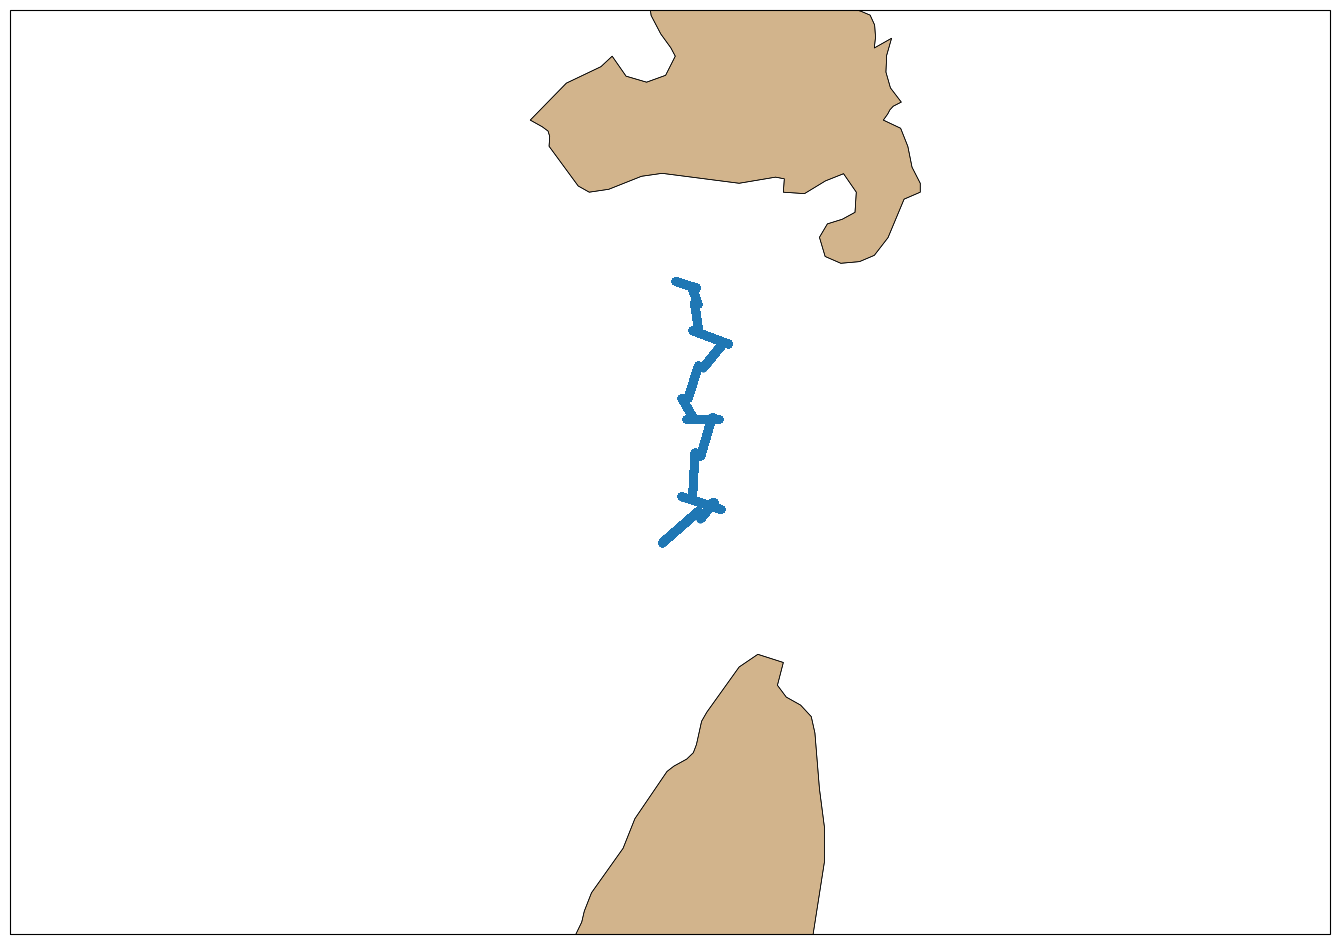

In [9]:
## Map extent
###### Dominica
# lon1 = -61.5
# lon2 = -61
# lat1 = 14.6
# lat2 = 15.4

##### St. Lucia
lon1 = -60.5
lon2 = -61.5
lat1 = 13.9
lat2 = 14.6

# ###### St. Vincent
# lon1 = -61.5
# lon2 = -61
# lat1 = 14
# lat2 = 13

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(testdf.longitude.values,testdf.latitude.values,'.')


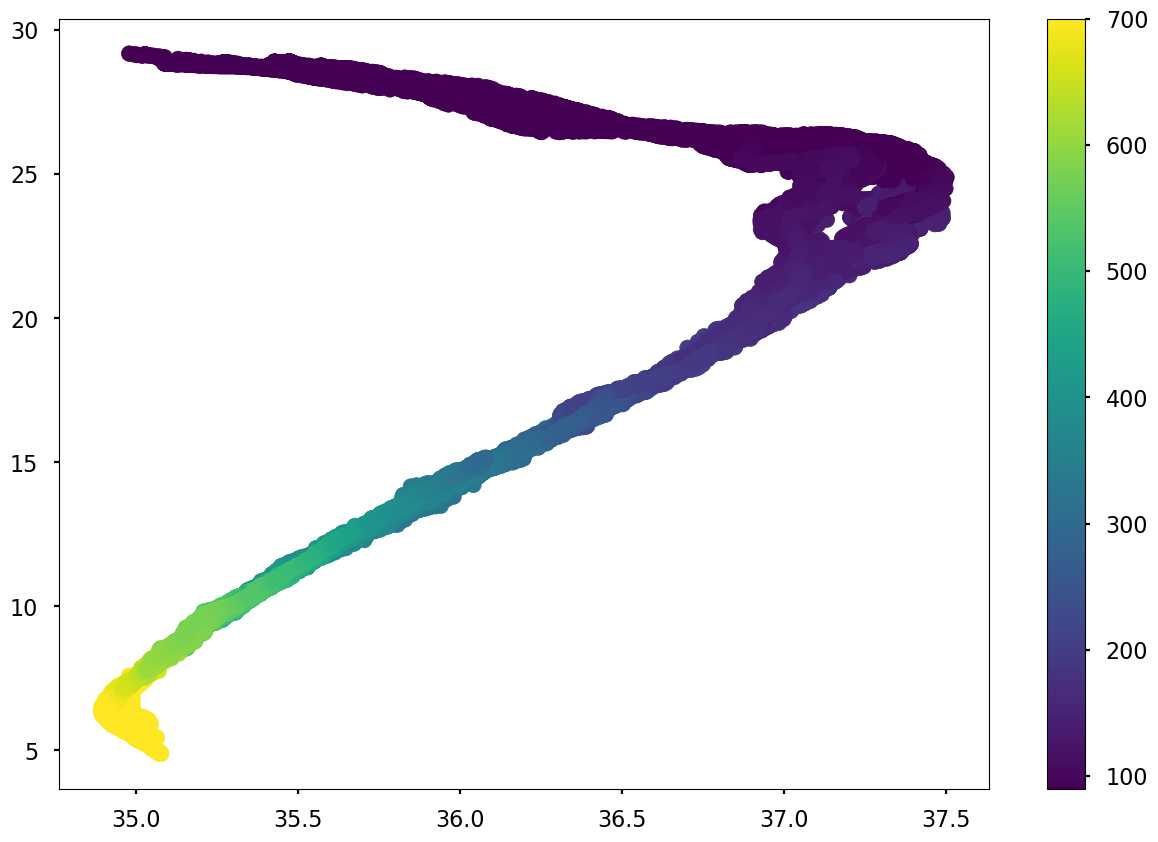

In [10]:
plt.figure(figsize=(15,10))
plt.scatter(testdf.absolute_salinity.values,testdf.conservative_temperature.values,c=testdf.depth_interpolated.values,vmin=700,vmax=100)

plt.colorbar()

(200.0, 0.0)

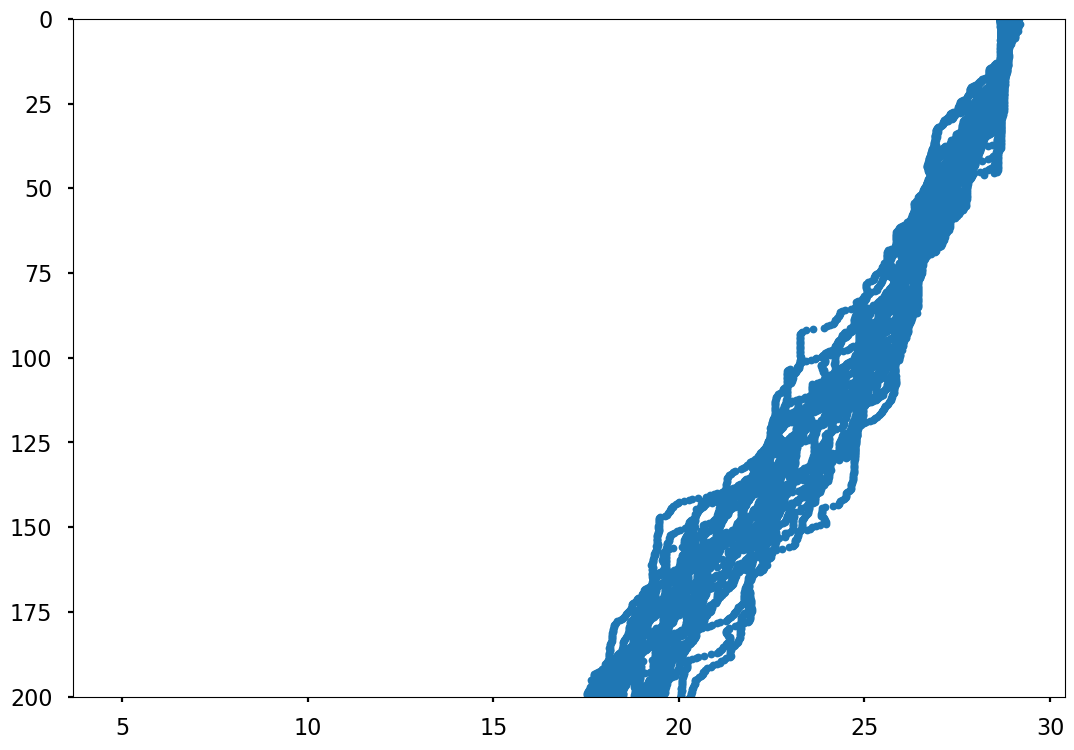

In [11]:
plt.plot(testdf.conservative_temperature.values,testdf.depth_interpolated.values,'.')
plt.ylim(200,0)

(200.0, 0.0)

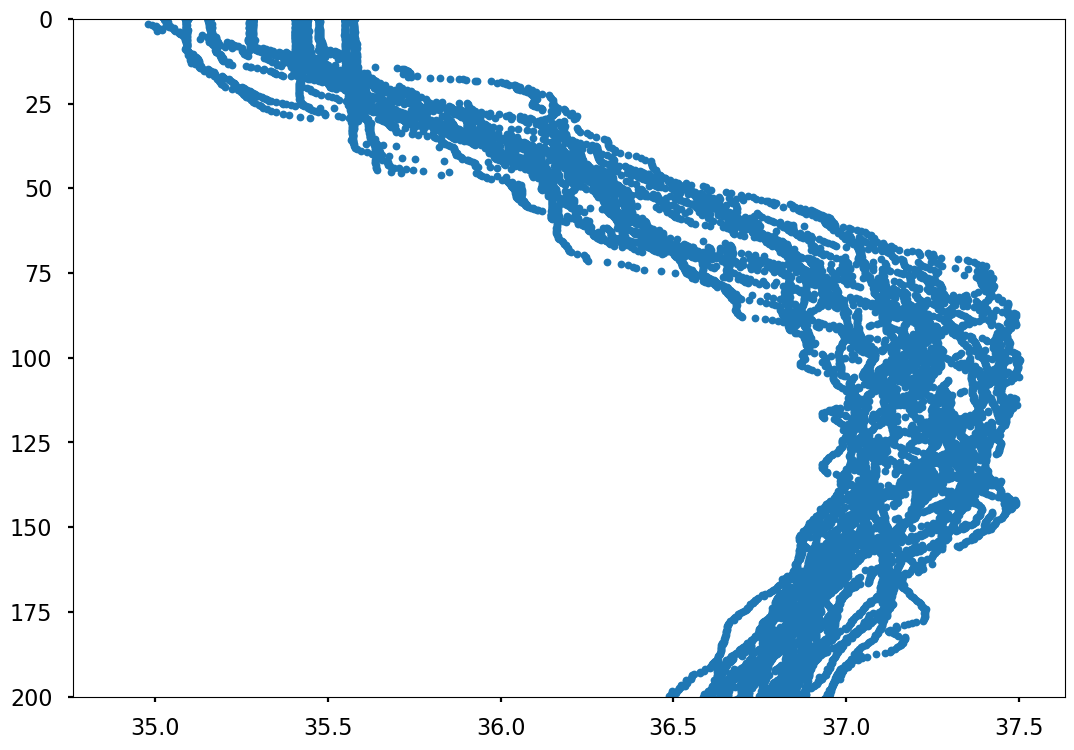

In [12]:
plt.plot(testdf.absolute_salinity.values,testdf.depth_interpolated.values,'.')
plt.ylim(200,0)

In [14]:
def calc_transect_angle(df):
    df2 = df.sort_values('latitude')
    
    def latlong_to_3d(latr, lonr):
        """Convert a point given latitude and longitude in radians to
        3-dimensional space, assuming a sphere radius of one."""
        return np.array((
            math.cos(latr) * math.cos(lonr),
            math.cos(latr) * math.sin(lonr),
            math.sin(latr)
        ))

    def angle_between_vectors_degrees(u, v):
        """Return the angle between two vectors in any dimension space,
        in degrees."""
        return np.degrees(
            math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))

    # The points in tuple latitude/longitude degrees space
    A = (df2.longitude.values[0],df2.latitude.values[0])
    B = (df2.longitude.values[-1],df2.latitude.values[-1])
    C = (df2.longitude.values[-1],df2.latitude.values[0])

    # Convert the points to numpy latitude/longitude radians space
    a = np.radians(np.array(A))
    b = np.radians(np.array(B))
    c = np.radians(np.array(C))

    # The points in 3D space
    a3 = latlong_to_3d(*a)
    b3 = latlong_to_3d(*b)
    c3 = latlong_to_3d(*c)

    # Vectors in 3D space
    a3vec = a3 - b3
    c3vec = c3 - b3

    # Find the angle between the vectors in 2D space
    angle = angle_between_vectors_degrees(a3vec, c3vec)
    
    return angle


def subsect_to_transect_df_to_transport_ds(df, start_time, end_time, lat_grid_dy=0.05, geo_dz=2):
    df = df[(df.time>= start_time) & (df.time<=end_time)]
    
    ## Now actuallly subset by file names so we get the full record
    start_file = df.source_file.iloc[0]
    end_file = df.source_file.iloc[-1]
    
    ## New start and end times because can't trust subsetting by file name is in ORDER
    new_start_time = gdf[gdf.source_file == start_file].time.min()
    new_end_time = gdf[gdf.source_file == end_file].time.max()
    
    df = gdf[(gdf.time>= new_start_time) & (gdf.time<=new_end_time)]
    ## first drop where lon/lat are nan
    df = df[df['sigma0'].notna()]
    
    ## then drop where lon/lat are nan
    df = df[df['latitude'].notna()]

    ## find min and max latitude for lat grid
    min_lat = df.latitude.values.min()
    max_lat = df.latitude.values.max()
    min_lon = df.longitude.values.min()
    max_lon = df.longitude.values.max()
    ## make latitude grid
    lat_gridt = np.arange(min_lat, max_lat, lat_grid_dy) 
    ## take the mean longitude for calculating the grid distance
    mean_lon = np.nanmean(df.longitude.values)

    ## this is the grid dy in meters then (0.05 degree latitude grid sizing is ~5.5 km)
    #dy = dist_from_lat_lon(lat_gridt[0],mean_lon,lat_gridt[1],mean_lon)
    ## this is the grid dy in meters, actually using the "angle" of the transect by using the true start and end lon
    ## (keep checking if 0.05 degree latitude grid sizing is ~5.8 km)
    dy = dist_from_lat_lon(min_lat,min_lon,max_lat,max_lon)/len(lat_gridt)
    transect_dist = dist_from_lat_lon(min_lat,min_lon,max_lat,max_lon)

    ## Now make the vertical (depth) grid
    ## for the depth grid just go to the max depth rounded to the nearest geo_dz'th place (i.e. geo_dz = 2, round to 911 m to 912)
    max_depth = round(df.depth_interpolated.max()/2)*2
    depth_gridt = np.arange(0,max_depth,geo_dz)

    ## now turn the temporary 1D grids into a 2D grid
    lat_grid, depth_grid = np.meshgrid(lat_gridt,depth_gridt)

    ## do the interpolation
    griddensity      = griddata((df.latitude.values,df.depth.values), df.sigma0, (lat_grid, depth_grid), method='linear')
    ## also do it for t,s,O2 because that's what the analysis will eventually focus on
    gridtemperature  = griddata((df.latitude.values,df.depth.values), df.conservative_temperature, (lat_grid, depth_grid), method='linear')
    gridsalinity     = griddata((df.latitude.values,df.depth.values), df.absolute_salinity, (lat_grid, depth_grid), method='linear')
    gridoxygen       = griddata((df.latitude.values,df.depth_interpolated.values), df.oxygen_concentration_shifted, (lat_grid, depth_grid), method='linear')
    
    ## now get the depth averaged current on this latitude grid
    grid_du = np.empty(len(lat_gridt))
    grid_du[:] = 0
    ## also do this for the mean oxygen time shift, not as meaningful but still want to keep track of it
    mean_time_shift = np.empty(len(lat_gridt))
    mean_time_shift[:] = np.nan

    ## Loop to compile DAC in each latitude bin and take mean
    for x in np.arange(0,len(lat_gridt)-1):
        subset_df = df[(df.latitude >= lat_gridt[x]) & (df.latitude <= lat_gridt[x+1])]
        ## Do a quick DAC QAQC, set DAC greater than 10 m/s to nan
        subset_df.u[np.abs(subset_df.u) > 5] = np.nan
        ## take mean DAC in that latitude bin
        grid_du[x] = np.nanmean(subset_df.u.values)

    
    ## drop column if all are na
    drop_ind = ~np.all(np.isnan(griddensity), axis=0)

    griddensity = griddensity[:,drop_ind]
    gridtemperature = gridtemperature[:,drop_ind]
    gridsalinity = gridsalinity[:,drop_ind]
    gridoxygen = gridoxygen[:,drop_ind]
    grid_du = grid_du[drop_ind]
    lat_gridt = lat_gridt[drop_ind]

    ## Calculate d(rho)/d(y)
    d_rho_dy = np.gradient(griddensity,dy,axis=1)

    ## Calculate d(u)/d(z)
    CF = sw.extras.f(df.latitude.values.mean())
    g = sw.eos80.g(df.latitude.values.mean(), 0)
    therm_wind = (1/CF)*(g/1027)*d_rho_dy

    ## Now integrate d(u)/d(z) vertically to get u
    ## replace nan with zeros for integration
    #therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0
    ## drop column if all are na
    #therm_wind = therm_wind[:,~np.all(np.isnan(therm_wind), axis=0)]

    ## flip to integrate from bottom and then flip back, this puts the level of no motion at the bottom of the profile
    rel_Vg = integrate.cumtrapz(therm_wind[::-1,:], dx=geo_dz, initial=0, axis=0)[::-1,:]

    ## Now add the reference velocity
    vref = grid_du - np.nanmean(rel_Vg,axis=0)
    Vgeo = rel_Vg + vref
    
    ## Determine transect angle off vertical and rotate geostrophic velocity to EW
    VgeoEW = Vgeo*np.cos(np.deg2rad(calc_transect_angle(df)))
    
    ## Calculate mid-point time
    start_time = np.nanmin(pd.to_datetime(df.time[df['time'].notna()]))
    end_time   = np.nanmax(pd.to_datetime(df.time[df['time'].notna()]))
    dt = (end_time-start_time)/2
    mid_time = pd.to_datetime(df.time.values)[0]+dt

    ## Now save!
    geo_grid_ds = xr.Dataset(
        data_vars=dict(
            Vgeo =(["depth", "latitude"], Vgeo),
            VgeoEW =(["depth", "latitude"], VgeoEW),
            density =(["depth", "latitude"], griddensity),
            temperature =(["depth", "latitude"], gridtemperature),
            salinity =(["depth", "latitude"], gridsalinity),
            oxygen =(["depth", "latitude"], gridoxygen),
            mean_du = (["latitude"],grid_du)),
        coords=dict(
            depth      = depth_gridt,
            latitude   = lat_gridt,
            start_time = start_time,
            end_time   = end_time,
            mid_time   = mid_time,
        ),
        attrs={'description': "Processed geostrophic velocity, temperature, salinity, density and time shifted oxygen gridded/interpolated onto transect latitude and depth grid",
        'min_lon': min_lon,
        'max_lon': max_lon,
        'mean_lon': mean_lon,
        'geo_dz': geo_dz,
        'dy': dy,
        'transect_dist': transect_dist}
    )

    return geo_grid_ds
    

In [15]:
dominica_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2023-06-01T03:00:00Z', end_time   = '2023-06-02T12:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Dominica_Transect_1_2023.nc'

dominica_df1.to_netcdf(save_name)



/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [16]:
dominica_df1

<xarray.Dataset>
Dimensions:      (depth: 195, latitude: 5)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 945 950 955 960 965 970
  * latitude     (latitude) float64 14.91 14.97 15.03 15.09 15.15
    start_time   datetime64[ns] 2023-06-01T03:04:28.840000
    end_time     datetime64[ns] 2023-06-02T14:41:19.500000
    mid_time     datetime64[ns] 2023-06-01T20:52:54.170000
Data variables:
    Vgeo         (depth, latitude) float64 0.2918 0.03986 ... -0.07171 0.115
    VgeoEW       (depth, latitude) float64 0.2833 0.03871 ... -0.06963 0.1116
    density      (depth, latitude) float64 1.023e+03 1.023e+03 ... 1.028e+03
    temperature  (depth, latitude) float64 28.29 28.34 28.51 ... 5.728 5.685
    salinity     (depth, latitude) float64 35.59 35.65 35.7 ... 35.07 35.06
    oxygen       (depth, latitude) float64 nan nan 196.8 nan ... nan 159.8 157.5
    mean_du      (latitude) float64 -0.07369 -0.05313 -0.1505 -0.2013 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.32718130012507
    max_lon:        -61.25992818762925
    mean_lon:       -61.29490472842791
    geo_dz:         5
    dy:             5911.475484647202
    transect_dist:  35468.852907883214

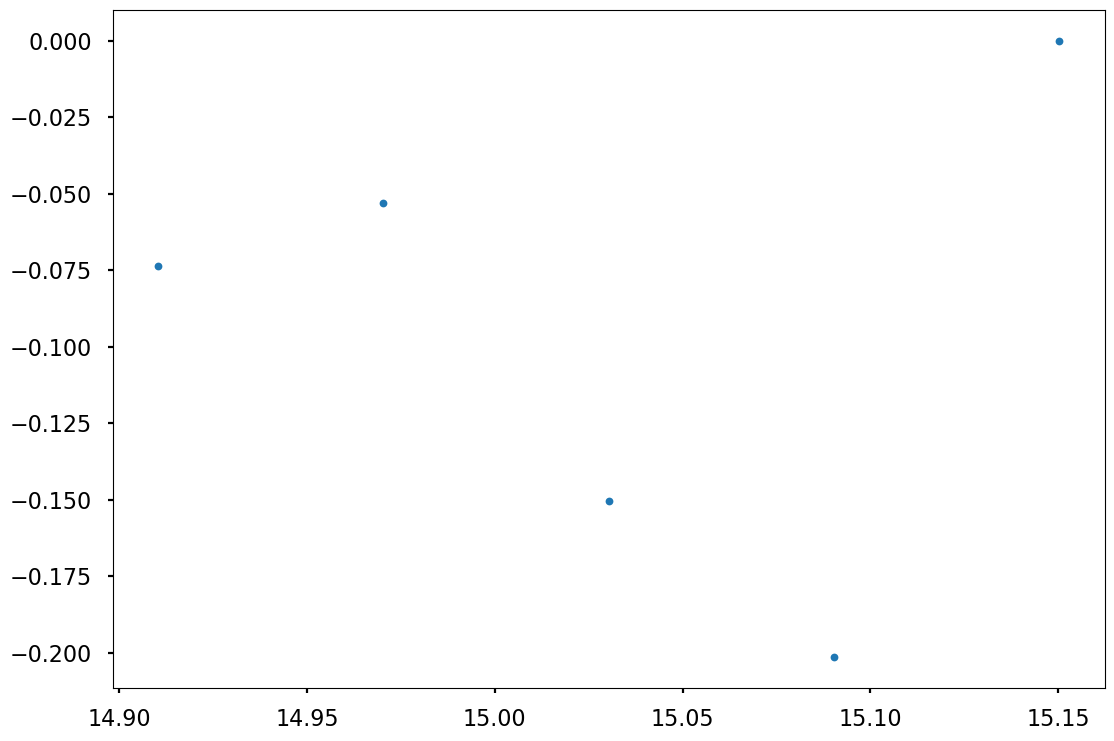

In [17]:
plt.plot(dominica_df1.latitude,dominica_df1.mean_du,'.')

Text(0.5, 0, 'Latitude')

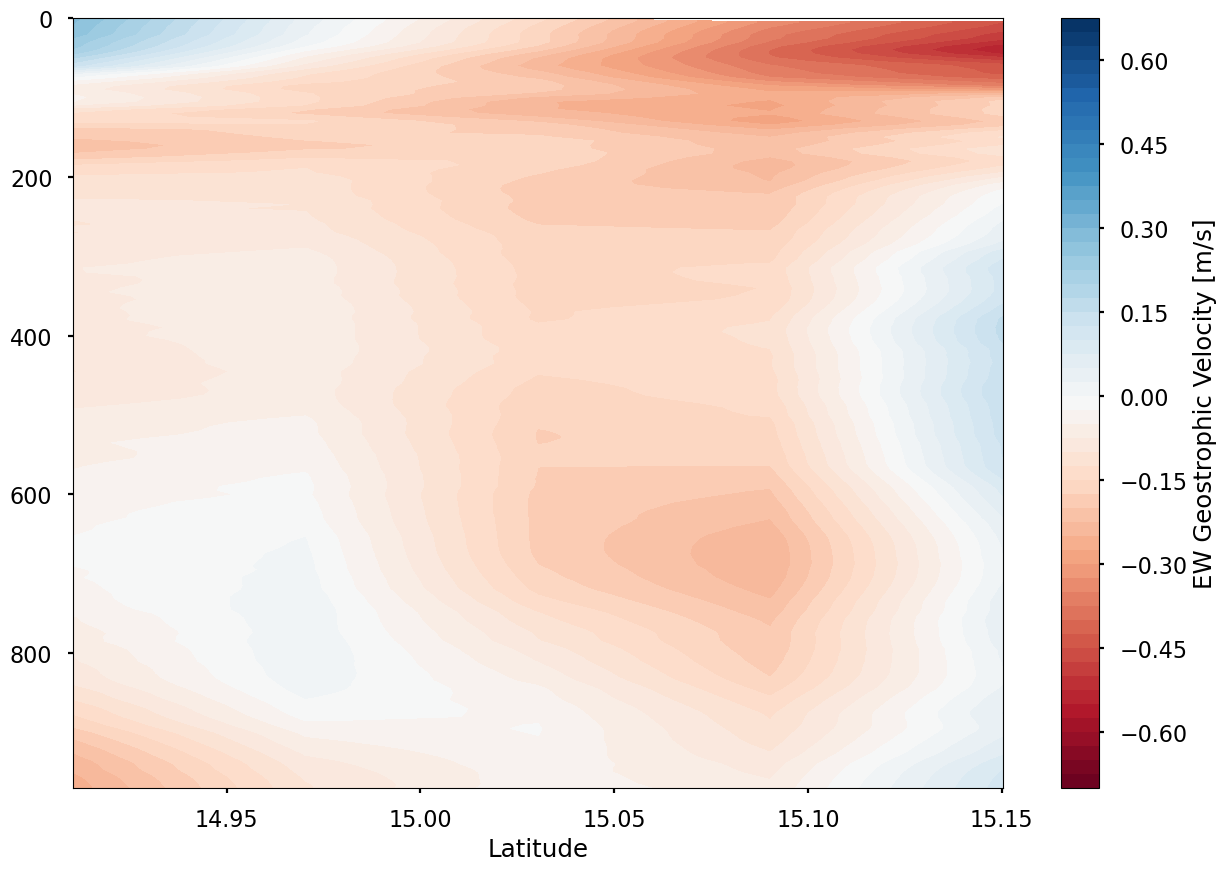

In [18]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df1.latitude,dominica_df1.depth,dominica_df1.VgeoEW,cmap='RdBu',levels=np.arange(-0.7,0.7,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

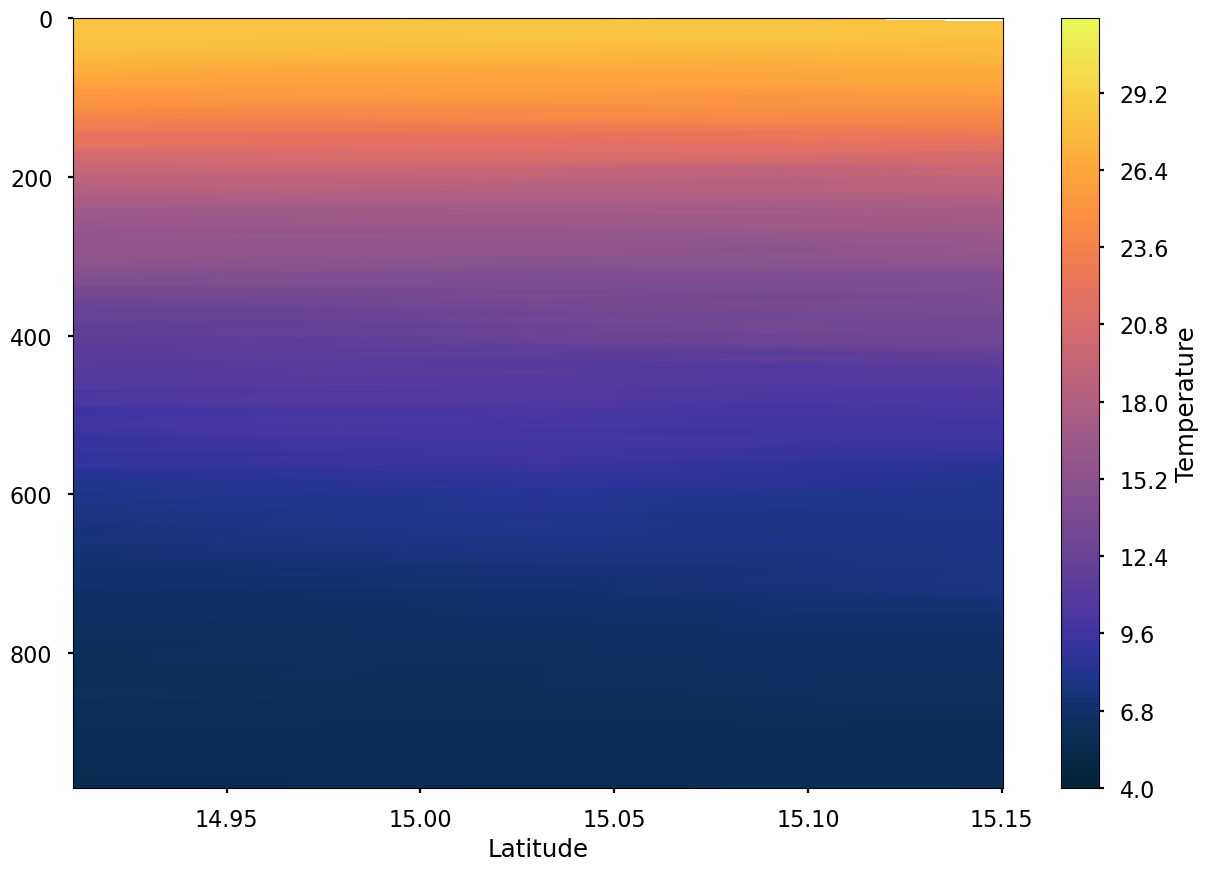

In [19]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df1.latitude,dominica_df1.depth,dominica_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,0.1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

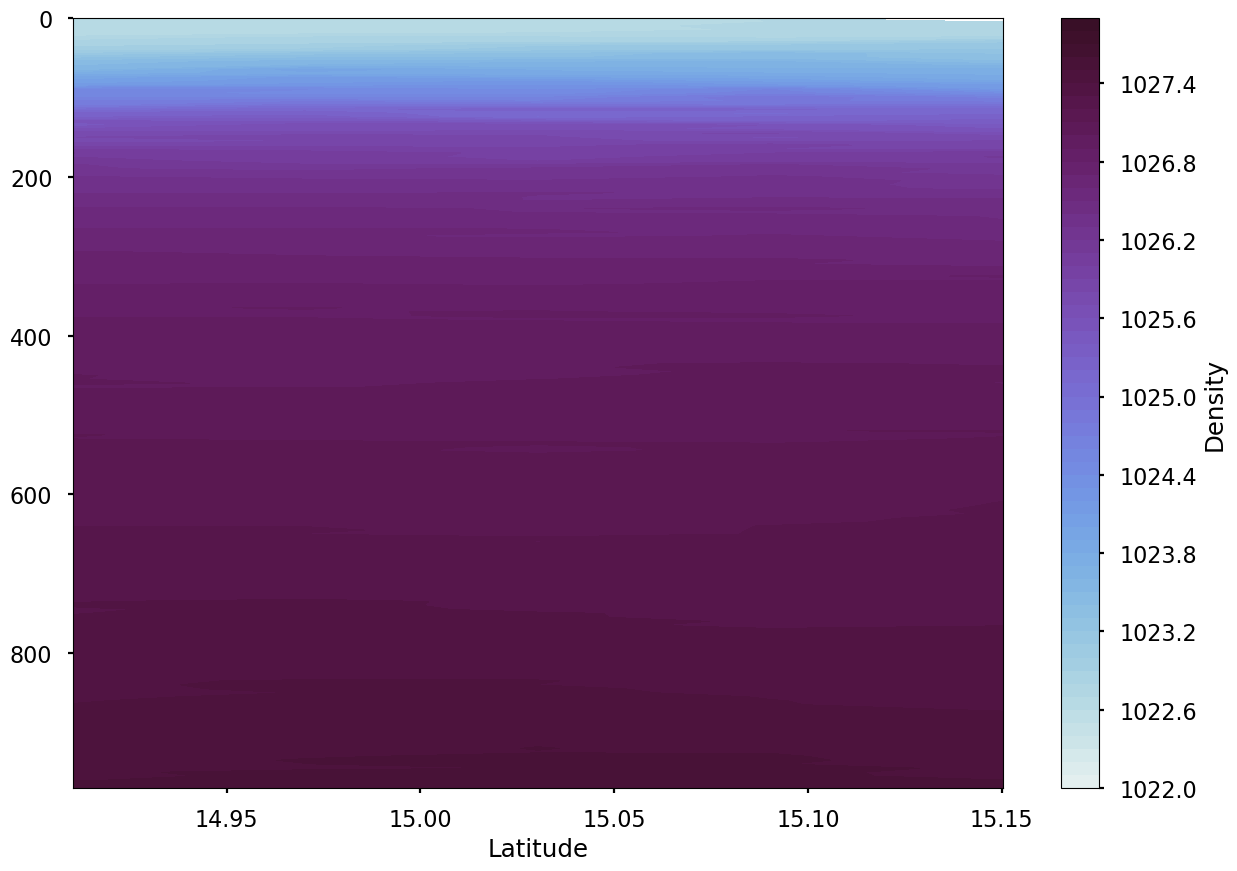

In [20]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df1.latitude,dominica_df1.depth,dominica_df1.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.1))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

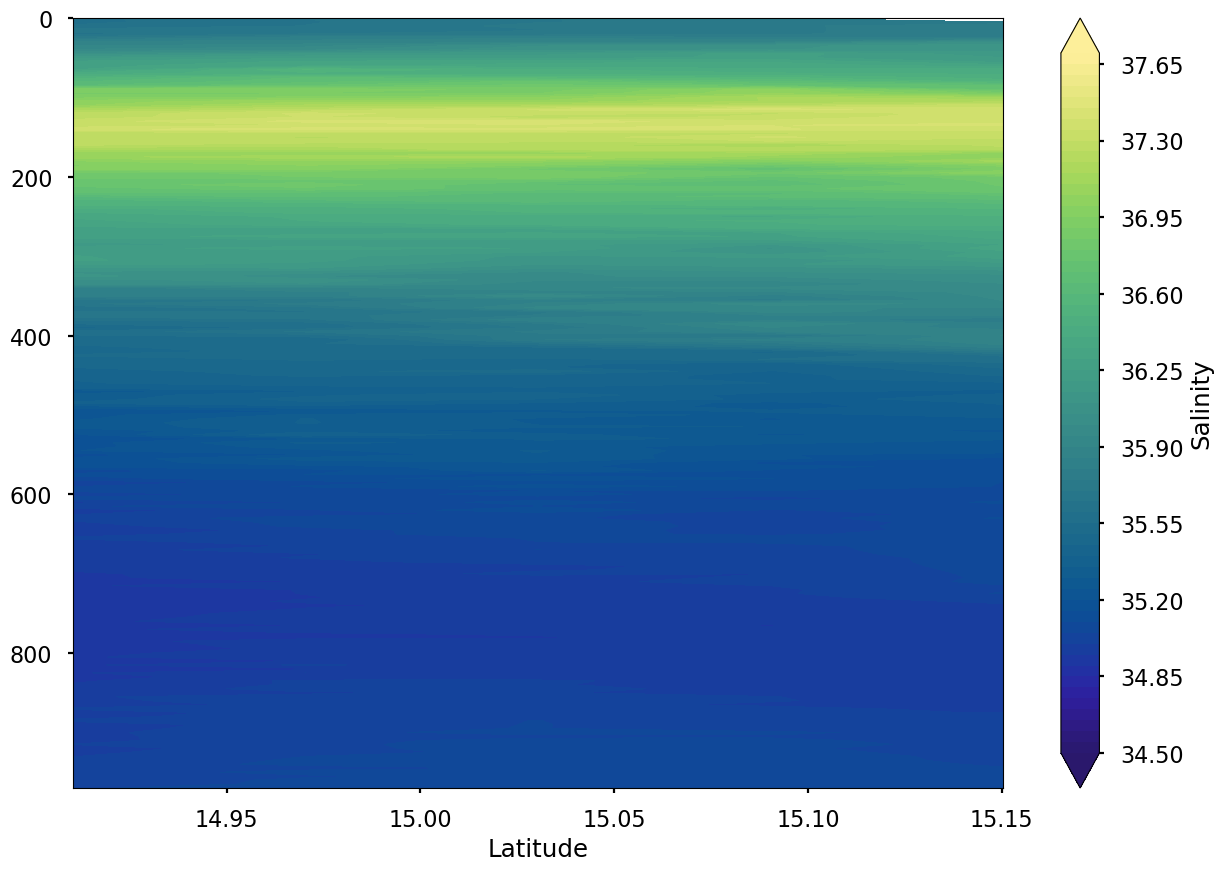

In [21]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df1.latitude,dominica_df1.depth,dominica_df1.salinity,cmap=cmo.haline,levels=np.arange(34.5,37.75,0.05),extend='both')
plt.gca().invert_yaxis()
plt.colorbar(label='Salinity')
plt.xlabel('Latitude')

## Dominica transect #2

In [22]:
dominica_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2023-06-02T15:00:00Z', end_time   = '2023-06-04T17:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Dominica_Transect_2_2023.nc'

dominica_df2.to_netcdf(save_name)


dominica_df2

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

<xarray.Dataset>
Dimensions:      (depth: 195, latitude: 5)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 945 950 955 960 965 970
  * latitude     (latitude) float64 14.89 14.95 15.01 15.07 15.13
    start_time   datetime64[ns] 2023-06-02T14:52:56.970000
    end_time     datetime64[ns] 2023-06-04T19:07:48.070000
    mid_time     datetime64[ns] 2023-06-03T17:00:22.520000
Data variables:
    Vgeo         (depth, latitude) float64 -0.2251 -0.01746 ... -0.2388 -0.1883
    VgeoEW       (depth, latitude) float64 -0.2202 -0.01709 ... -0.2336 -0.1842
    density      (depth, latitude) float64 1.023e+03 1.023e+03 ... 1.027e+03
    temperature  (depth, latitude) float64 28.61 28.49 28.84 ... 5.365 5.71 5.79
    salinity     (depth, latitude) float64 35.71 35.61 35.6 ... 35.07 35.06
    oxygen       (depth, latitude) float64 195.8 nan 196.0 196.3 ... nan nan nan
    mean_du      (latitude) float64 -0.009044 -0.0129 -0.1107 -0.1907 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.32110153730912
    max_lon:        -61.26419003058432
    mean_lon:       -61.28757942387346
    geo_dz:         5
    dy:             6274.257861677794
    transect_dist:  37645.54717006676

Text(0.5, 0, 'Latitude')

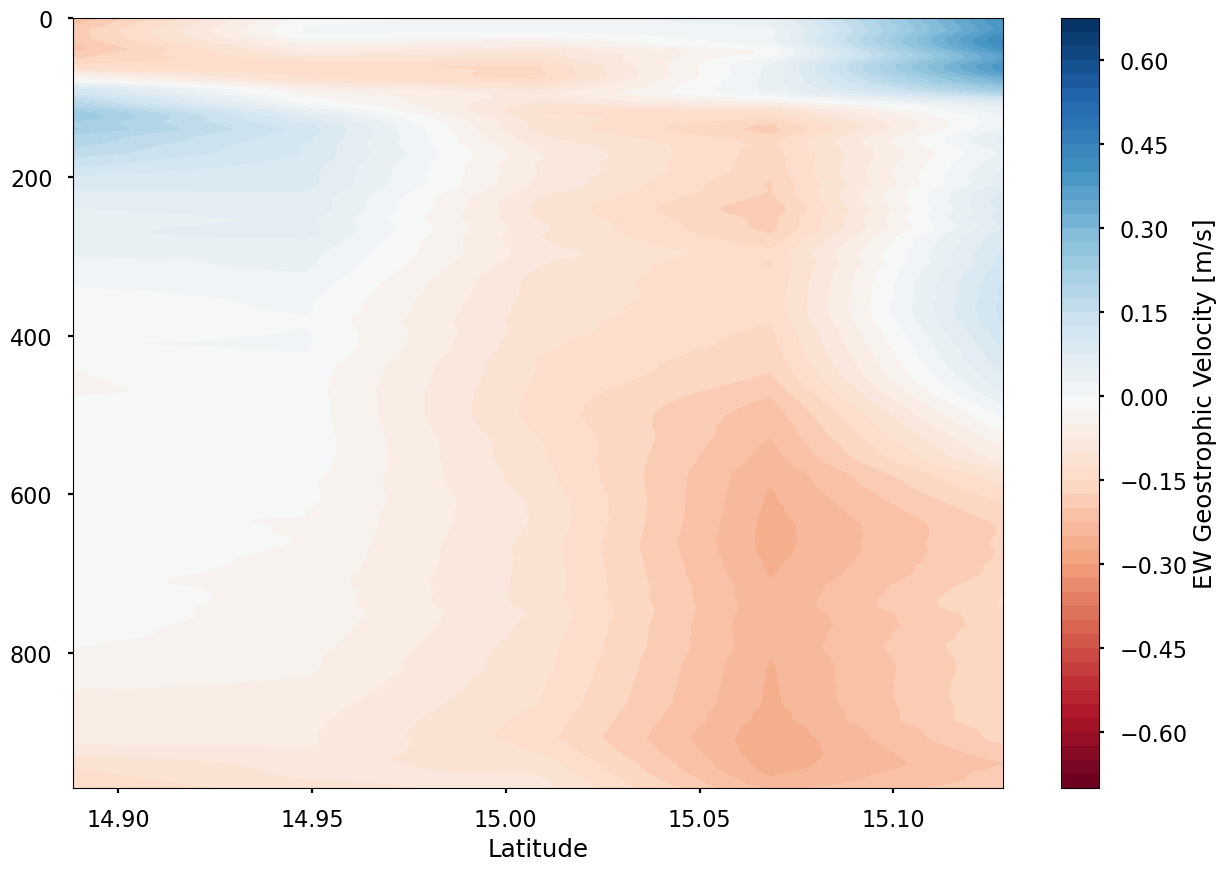

In [23]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df2.latitude,dominica_df2.depth,dominica_df2.VgeoEW,cmap='RdBu',levels=np.arange(-0.7,0.7,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

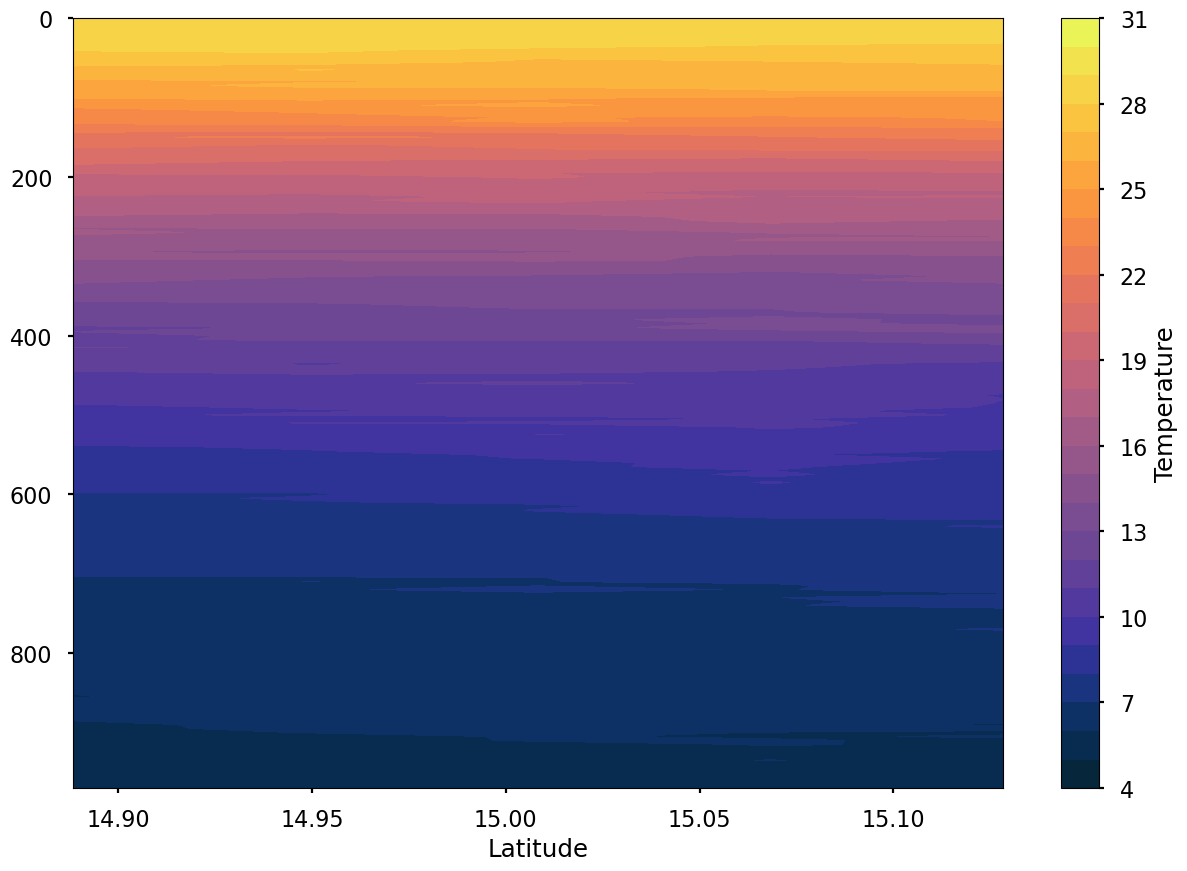

In [24]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df2.latitude,dominica_df2.depth,dominica_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

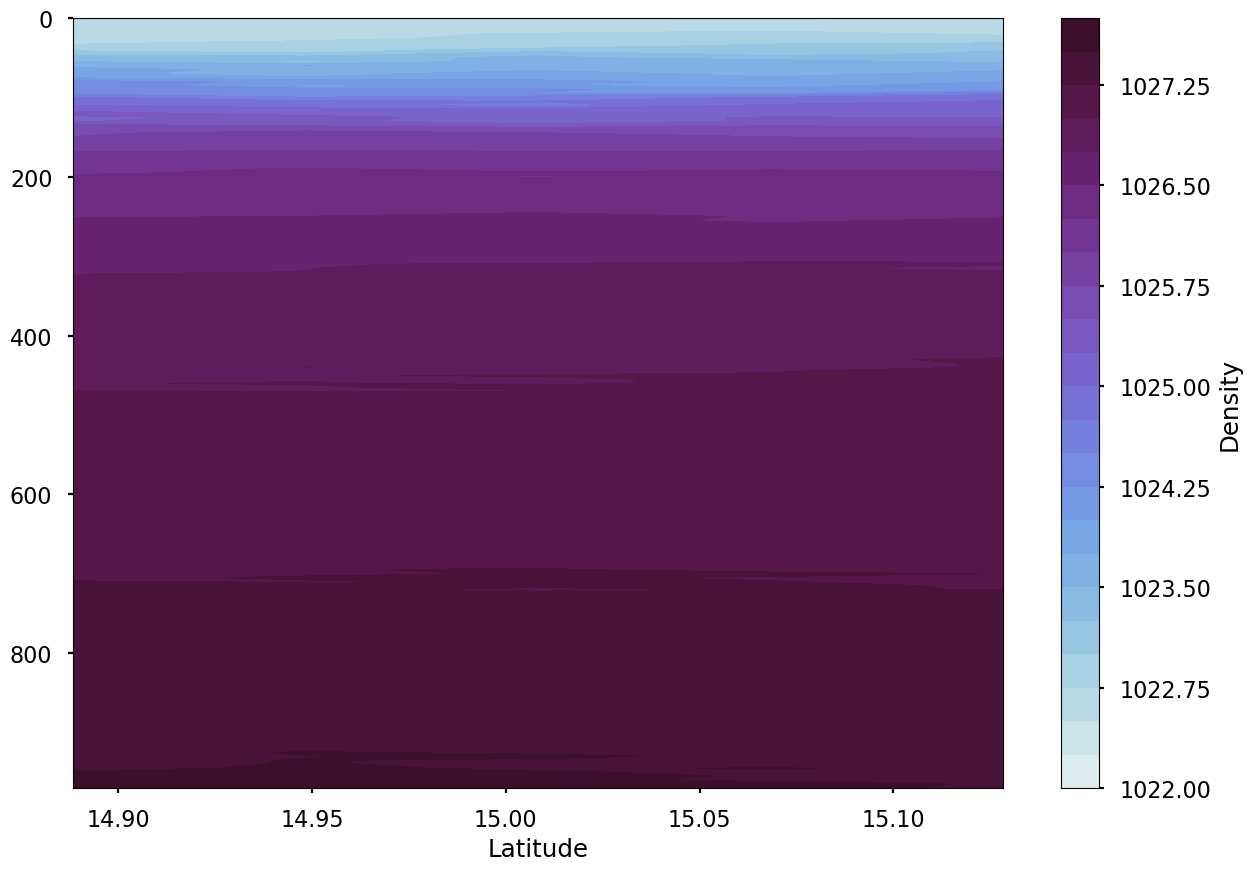

In [25]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df2.latitude,dominica_df2.depth,dominica_df2.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

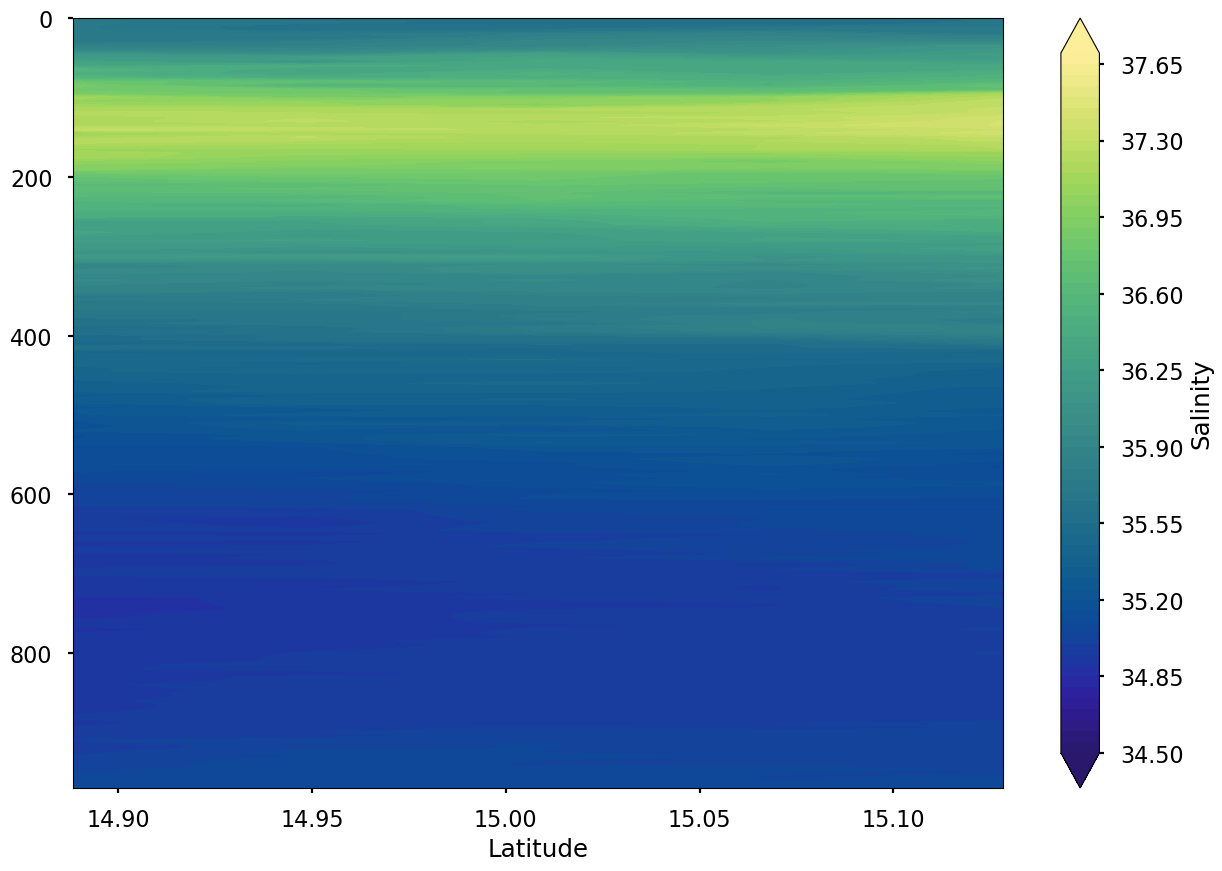

In [26]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df2.latitude,dominica_df2.depth,dominica_df2.salinity,cmap=cmo.haline,levels=np.arange(34.5,37.75,0.05),extend='both')
plt.gca().invert_yaxis()
plt.colorbar(label='Salinity')
plt.xlabel('Latitude')

## St Vincent #1

In [27]:
stvin_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2023-06-11T14:00:00Z',end_time   = '2023-06-15T12:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Vincent_Transect_1_2023.nc'

stvin_df1.to_netcdf(save_name)

stvin_df1

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

<xarray.Dataset>
Dimensions:      (depth: 196, latitude: 5)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 950 955 960 965 970 975
  * latitude     (latitude) float64 13.48 13.54 13.6 13.66 13.72
    start_time   datetime64[ns] 2023-06-11T14:08:54.990000
    end_time     datetime64[ns] 2023-06-15T15:03:56.630000
    mid_time     datetime64[ns] 2023-06-13T14:36:25.810000
Data variables:
    Vgeo         (depth, latitude) float64 nan nan -0.4054 ... 0.07278 0.1782
    VgeoEW       (depth, latitude) float64 nan nan -0.4043 ... 0.07259 0.1777
    density      (depth, latitude) float64 1.022e+03 1.022e+03 ... 1.028e+03
    temperature  (depth, latitude) float64 28.92 28.91 28.96 ... 5.197 5.264
    salinity     (depth, latitude) float64 34.98 34.81 34.76 ... 35.04 35.03
    oxygen       (depth, latitude) float64 nan 194.6 nan nan ... nan nan 160.6
    mean_du      (latitude) float64 -0.1573 -0.113 -0.1121 -0.1043 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.190535654671024
    max_lon:        -61.12422519406127
    mean_lon:       -61.15802615156306
    geo_dz:         5
    dy:             6431.984872867808
    transect_dist:  38591.90923720685

Text(0.5, 0, 'Latitude')

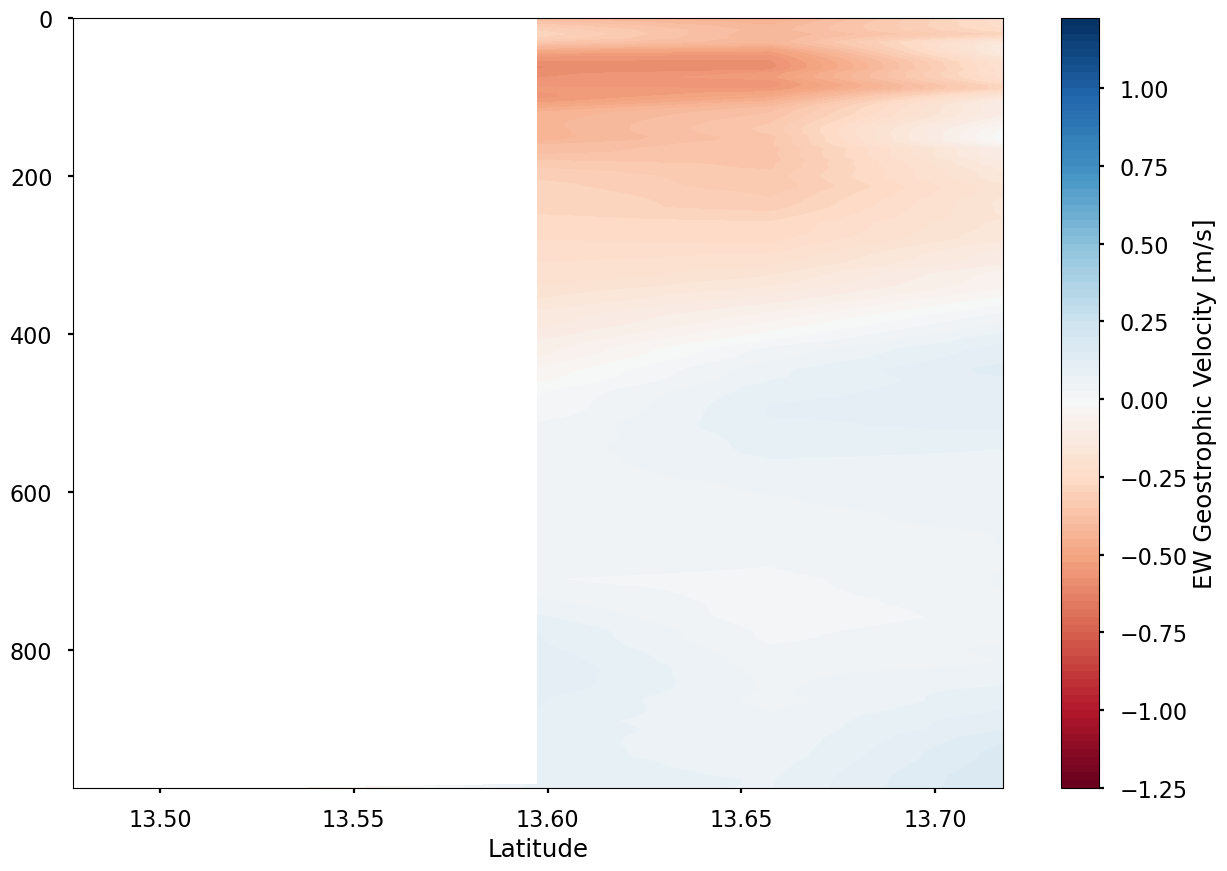

In [28]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df1.latitude,stvin_df1.depth,stvin_df1.VgeoEW,cmap='RdBu',levels=np.arange(-1.25,1.25,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

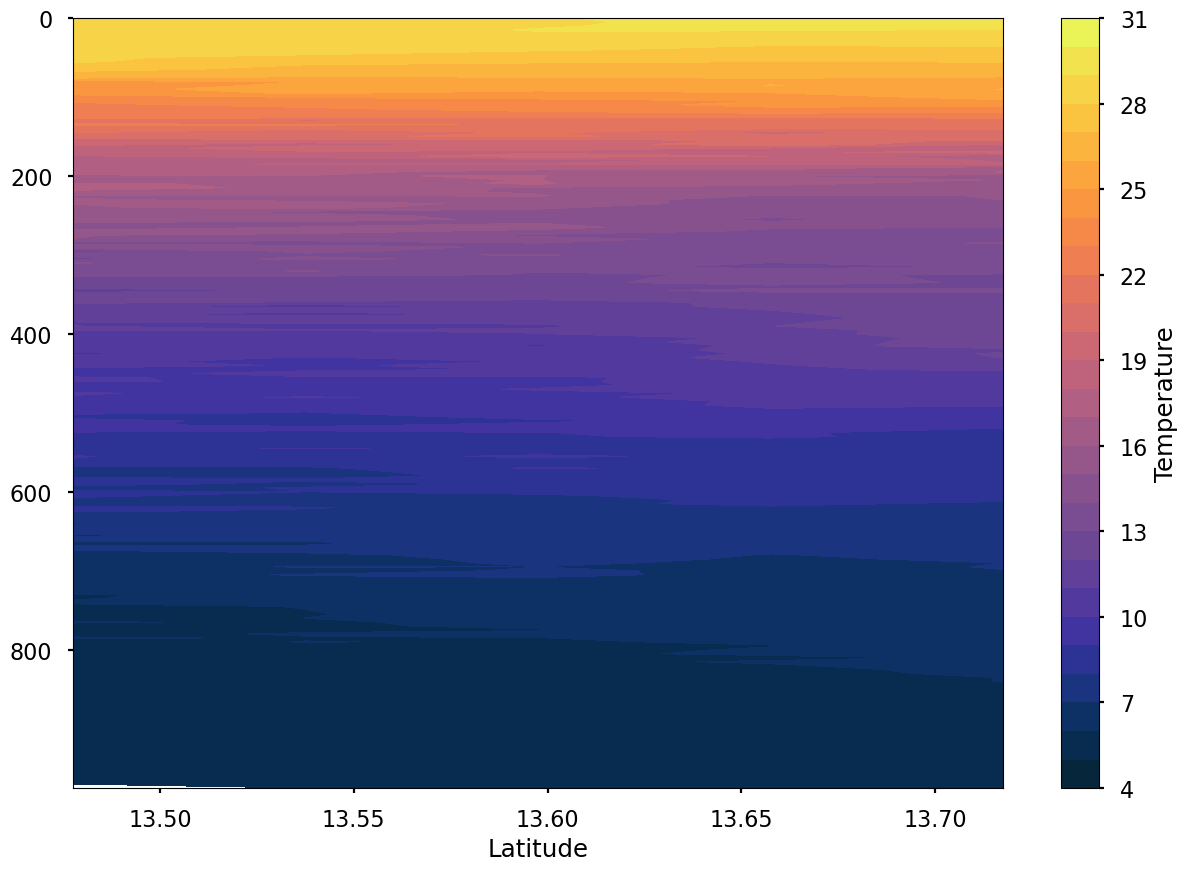

In [29]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df1.latitude,stvin_df1.depth,stvin_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

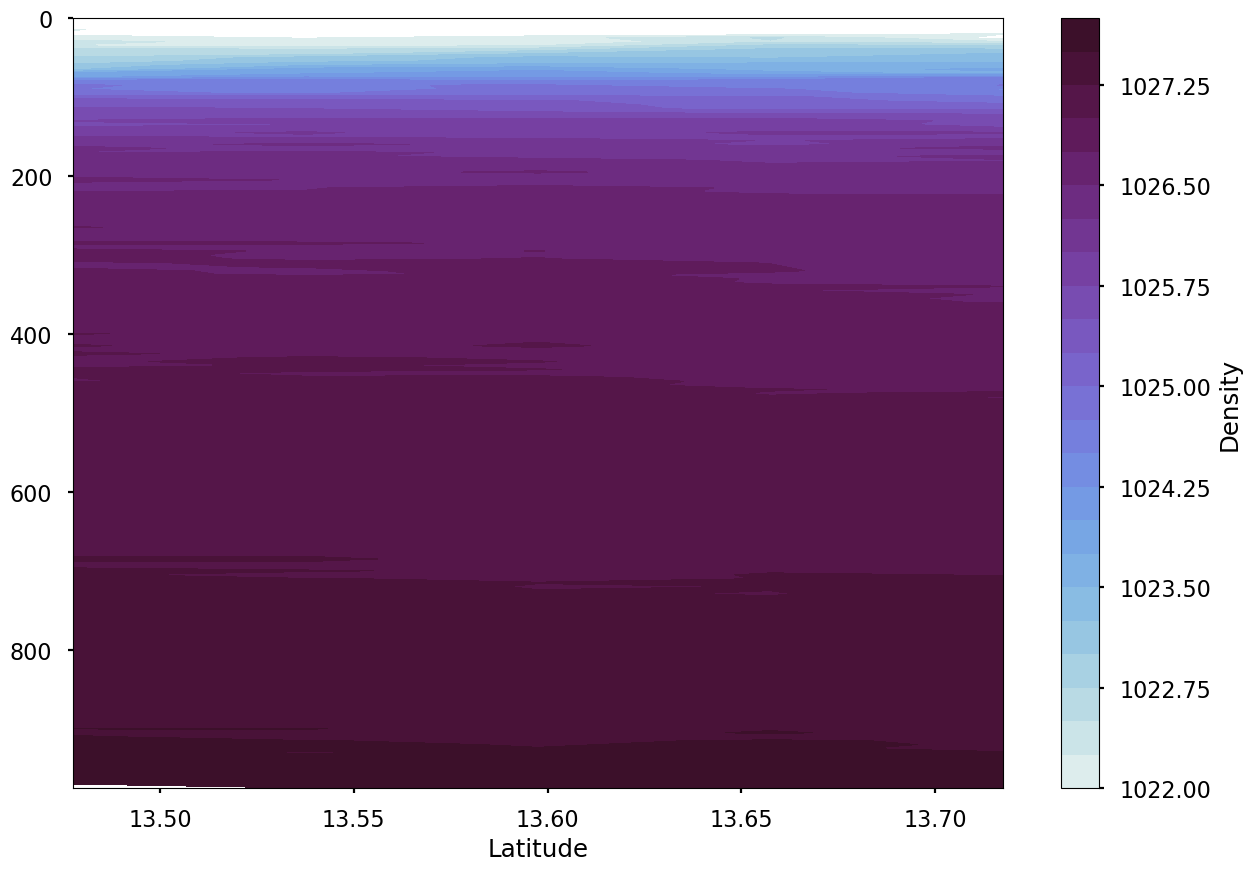

In [30]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df1.latitude,stvin_df1.depth,stvin_df1.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

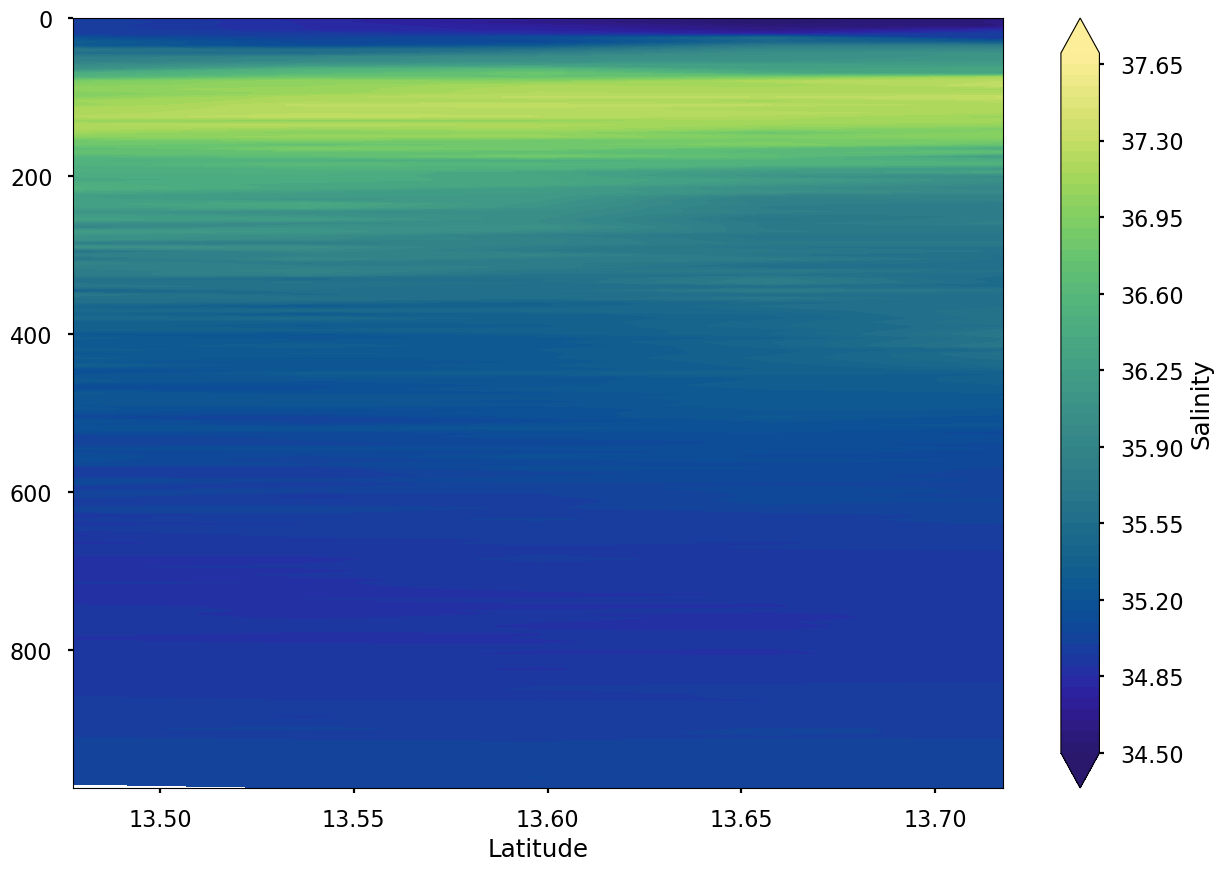

In [31]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df1.latitude,stvin_df1.depth,stvin_df1.salinity,cmap=cmo.haline,levels=np.arange(34.5,37.75,0.05),extend='both')
plt.gca().invert_yaxis()
plt.colorbar(label='Salinity')
plt.xlabel('Latitude')

## St. Vincent #2

In [32]:
stvin_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2023-06-15T19:00:00Z',end_time   = '2023-06-17T11:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Vincent_Transect_2_2023.nc'

stvin_df2.to_netcdf(save_name)

stvin_df2

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

<xarray.Dataset>
Dimensions:      (depth: 196, latitude: 6)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 950 955 960 965 970 975
  * latitude     (latitude) float64 13.49 13.55 13.61 13.67 13.73 13.79
    start_time   datetime64[ns] 2023-06-15T18:59:02.300000
    end_time     datetime64[ns] 2023-06-17T14:07:48.360000
    mid_time     datetime64[ns] 2023-06-16T16:33:25.330000
Data variables:
    Vgeo         (depth, latitude) float64 -0.8962 -0.139 ... -0.05533 0.0
    VgeoEW       (depth, latitude) float64 -0.8857 -0.1373 ... -0.05468 0.0
    density      (depth, latitude) float64 1.022e+03 1.022e+03 ... 1.028e+03 nan
    temperature  (depth, latitude) float64 28.79 28.76 28.97 ... 5.297 5.259 nan
    salinity     (depth, latitude) float64 34.87 34.86 35.02 ... 35.03 35.03 nan
    oxygen       (depth, latitude) float64 nan nan nan 195.2 ... nan nan nan nan
    mean_du      (latitude) float64 -0.02778 -0.06606 -0.01536 ... -0.05533 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.19487261455939
    max_lon:        -61.1287817809427
    mean_lon:       -61.15561181706738
    geo_dz:         5
    dy:             6274.7053940173055
    transect_dist:  43922.93775812114

Text(0.5, 0, 'Latitude')

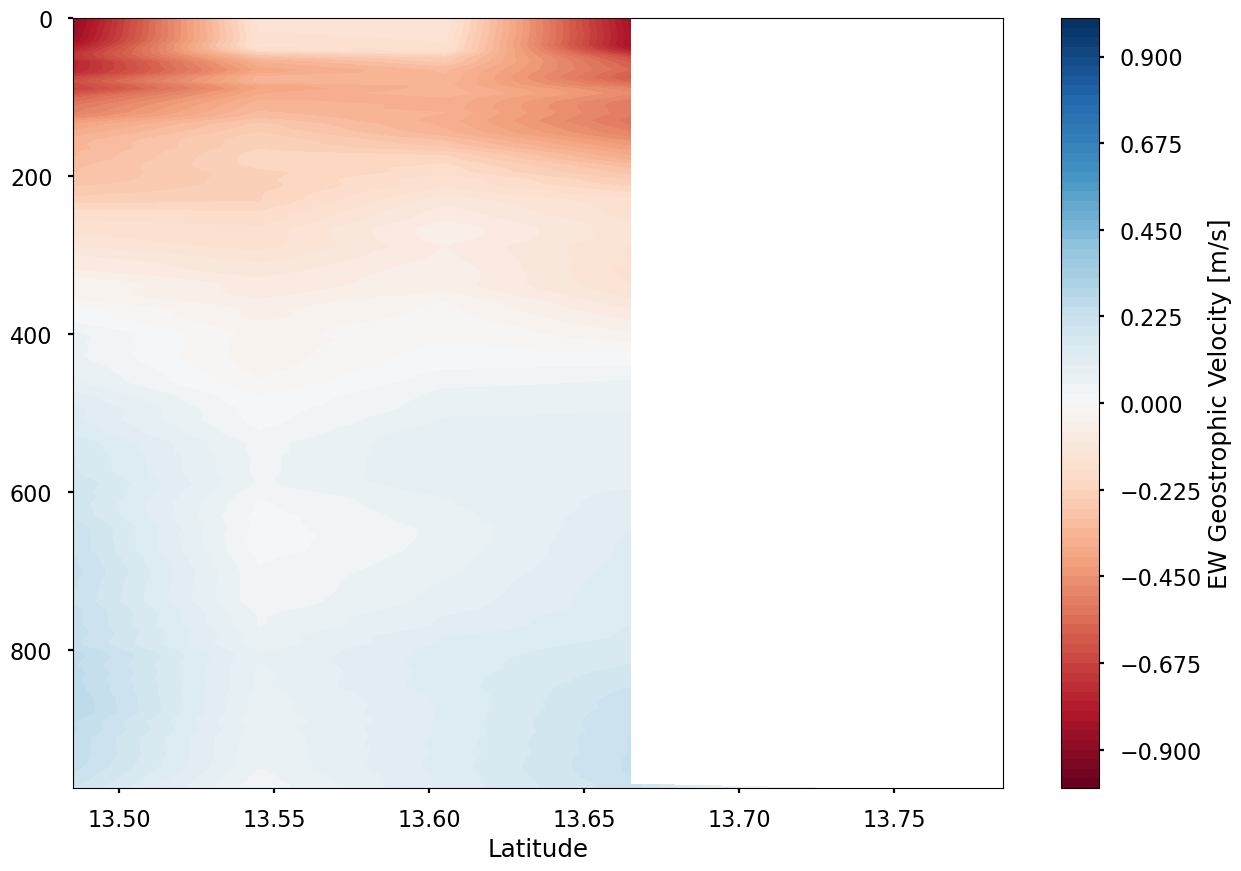

In [33]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df2.latitude,stvin_df2.depth,stvin_df2.VgeoEW,cmap='RdBu',levels=np.arange(-1,1.01,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

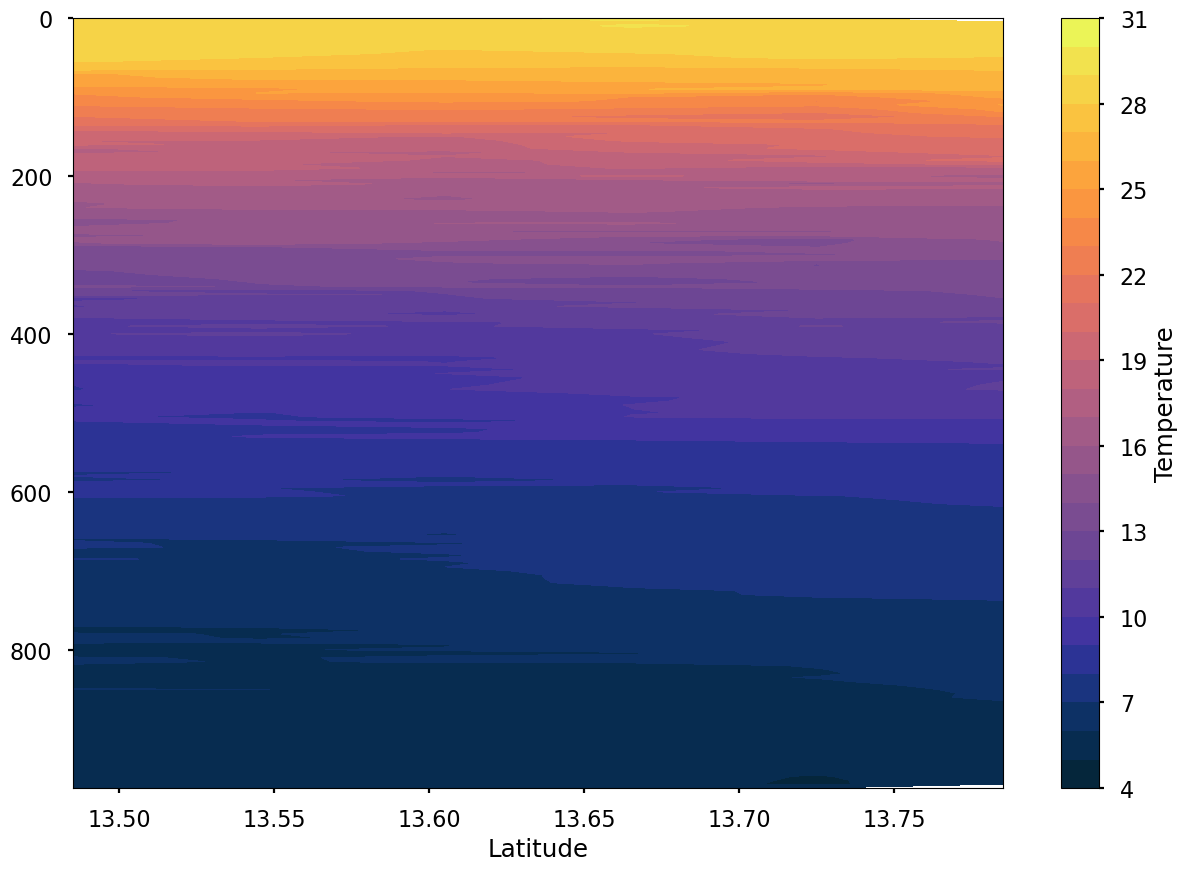

In [34]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df2.latitude,stvin_df2.depth,stvin_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

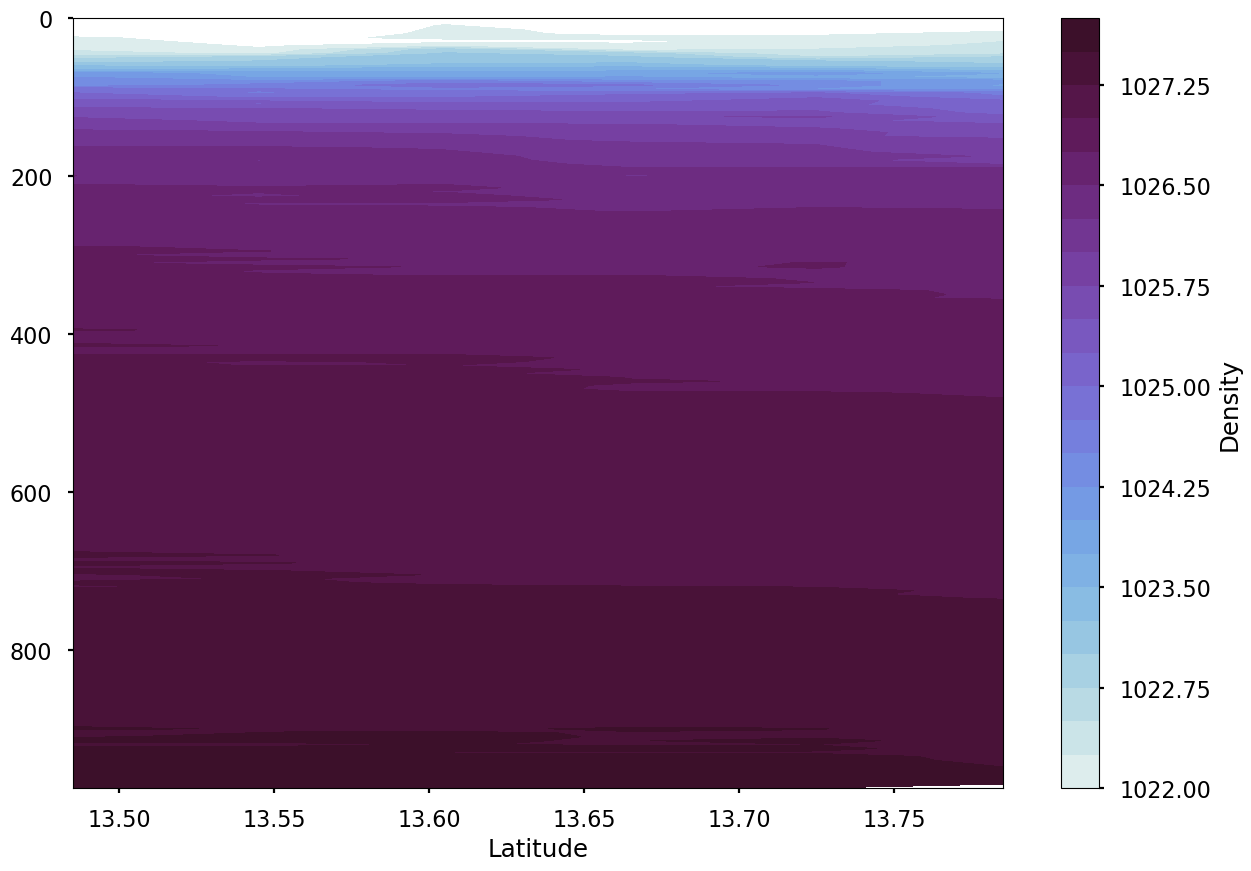

In [35]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df2.latitude,stvin_df2.depth,stvin_df2.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

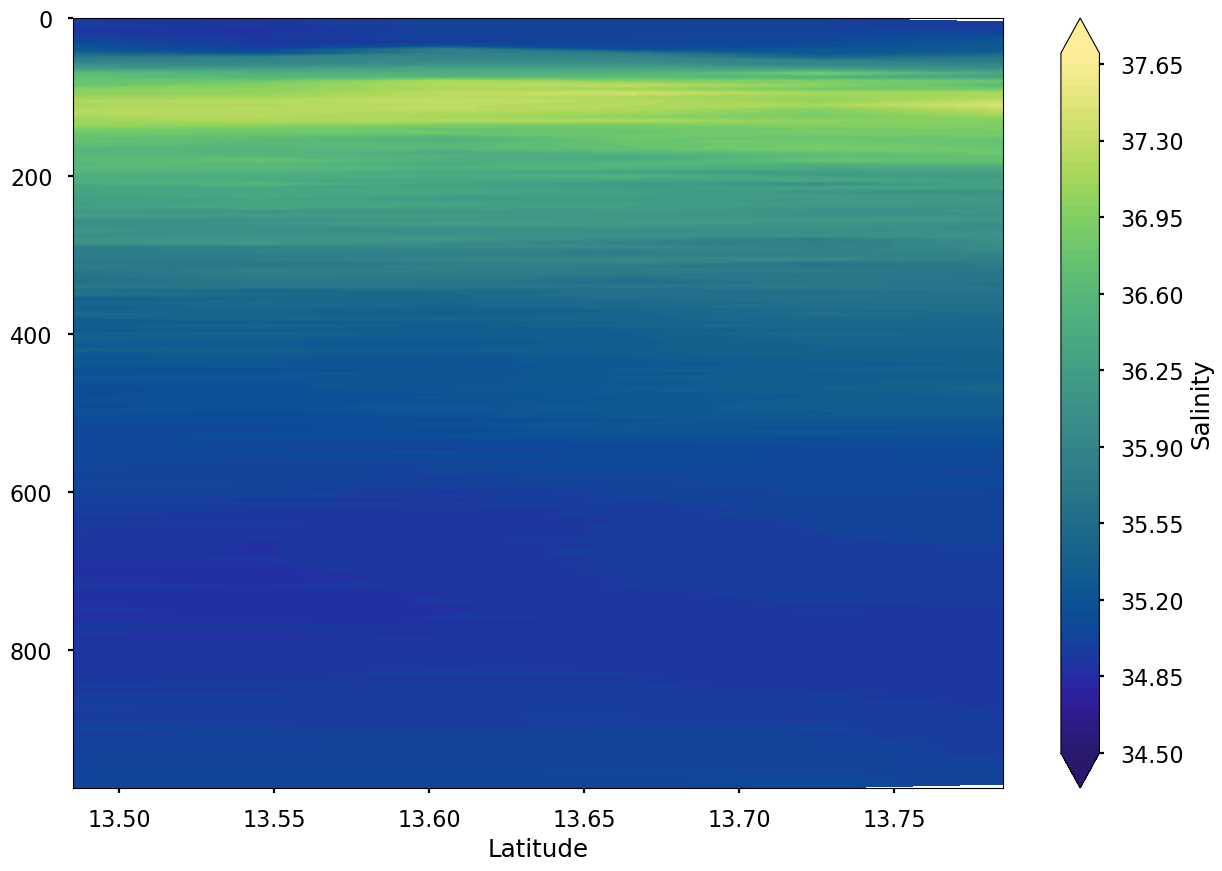

In [36]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df2.latitude,stvin_df2.depth,stvin_df2.salinity,cmap=cmo.haline,levels=np.arange(34.5,37.75,0.05),extend='both')
plt.gca().invert_yaxis()
plt.colorbar(label='Salinity')
plt.xlabel('Latitude')

## St Lucia #1

In [37]:
stluc_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2023-06-07T08:00:00Z',end_time   = '2023-06-09T02:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Lucia_Transect_1_2023.nc'

stluc_df1.to_netcdf(save_name)

stluc_df1

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

<xarray.Dataset>
Dimensions:      (depth: 196, latitude: 3)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 950 955 960 965 970 975
  * latitude     (latitude) float64 14.25 14.31 14.37
    start_time   datetime64[ns] 2023-06-07T06:31:44.780000
    end_time     datetime64[ns] 2023-06-09T02:32:57.530000
    mid_time     datetime64[ns] 2023-06-08T04:32:21.155000
Data variables:
    Vgeo         (depth, latitude) float64 nan nan nan ... -0.1349 -0.08749 0.0
    VgeoEW       (depth, latitude) float64 nan nan nan ... -0.1349 -0.08749 0.0
    density      (depth, latitude) float64 1.022e+03 1.022e+03 ... nan nan
    temperature  (depth, latitude) float64 28.89 28.78 28.8 ... nan nan nan
    salinity     (depth, latitude) float64 35.12 35.42 35.53 ... nan nan nan
    oxygen       (depth, latitude) float64 194.1 nan nan nan ... nan nan nan nan
    mean_du      (latitude) float64 -0.1349 -0.08749 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.01188212772991
    max_lon:        -60.95619722749002
    mean_lon:       -60.97999796104554
    geo_dz:         5
    dy:             5973.793569713398
    transect_dist:  23895.174278853592

Text(0.5, 0, 'Latitude')

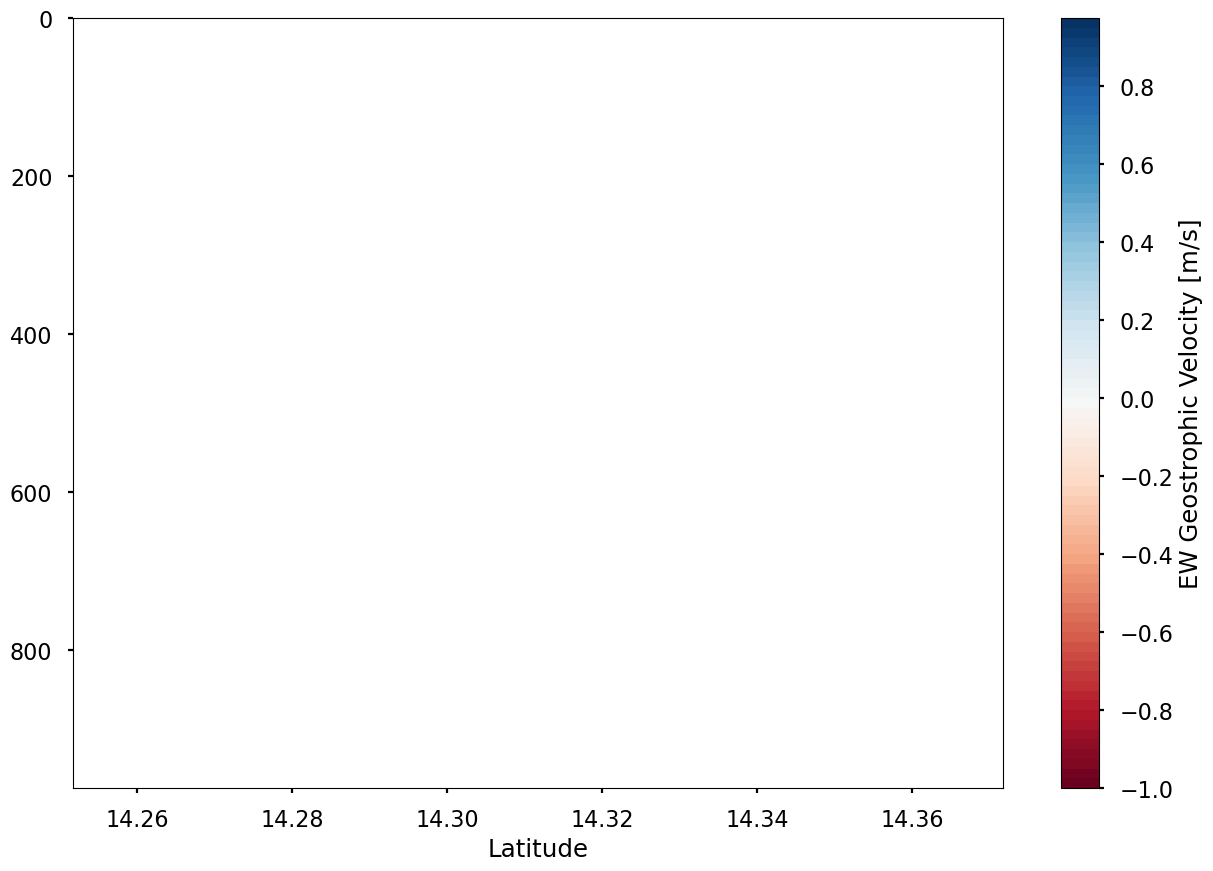

In [38]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df1.latitude,stluc_df1.depth,stluc_df1.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

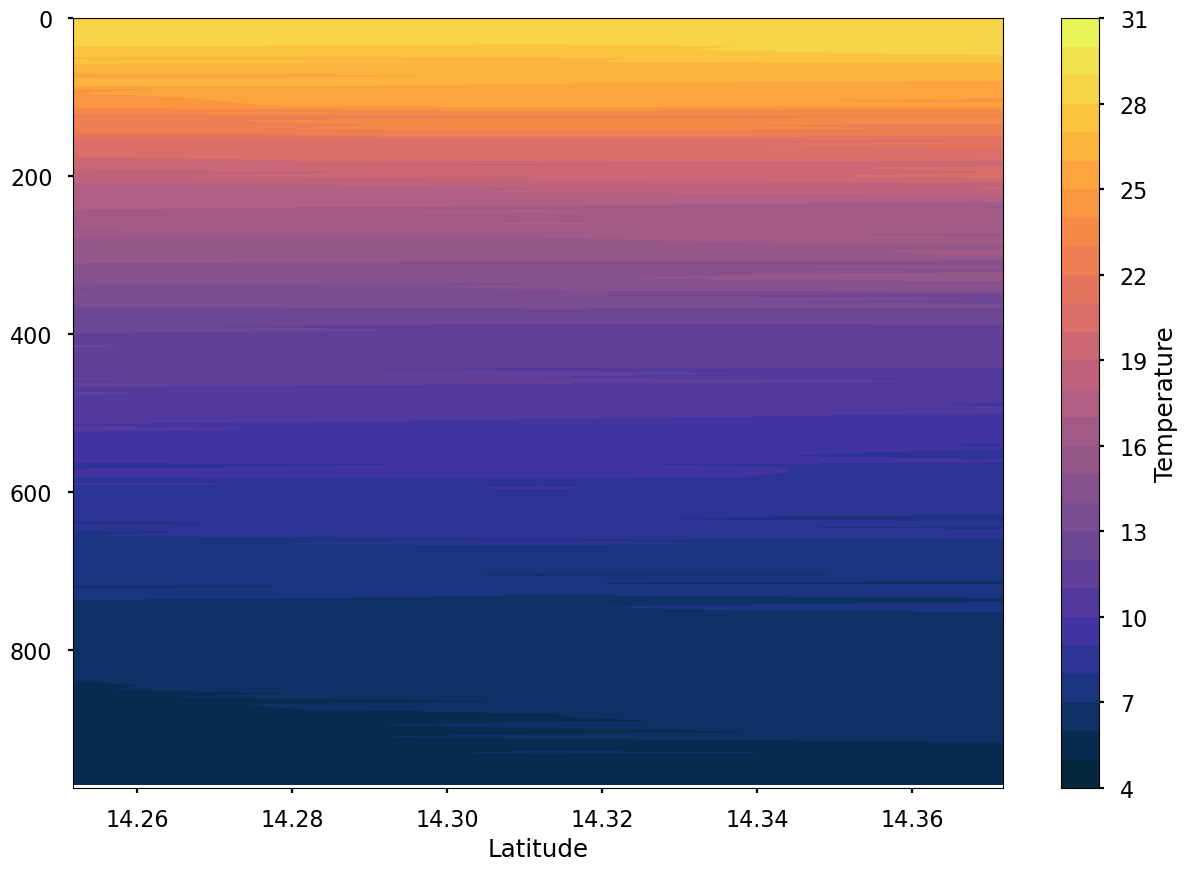

In [39]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df1.latitude,stluc_df1.depth,stluc_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

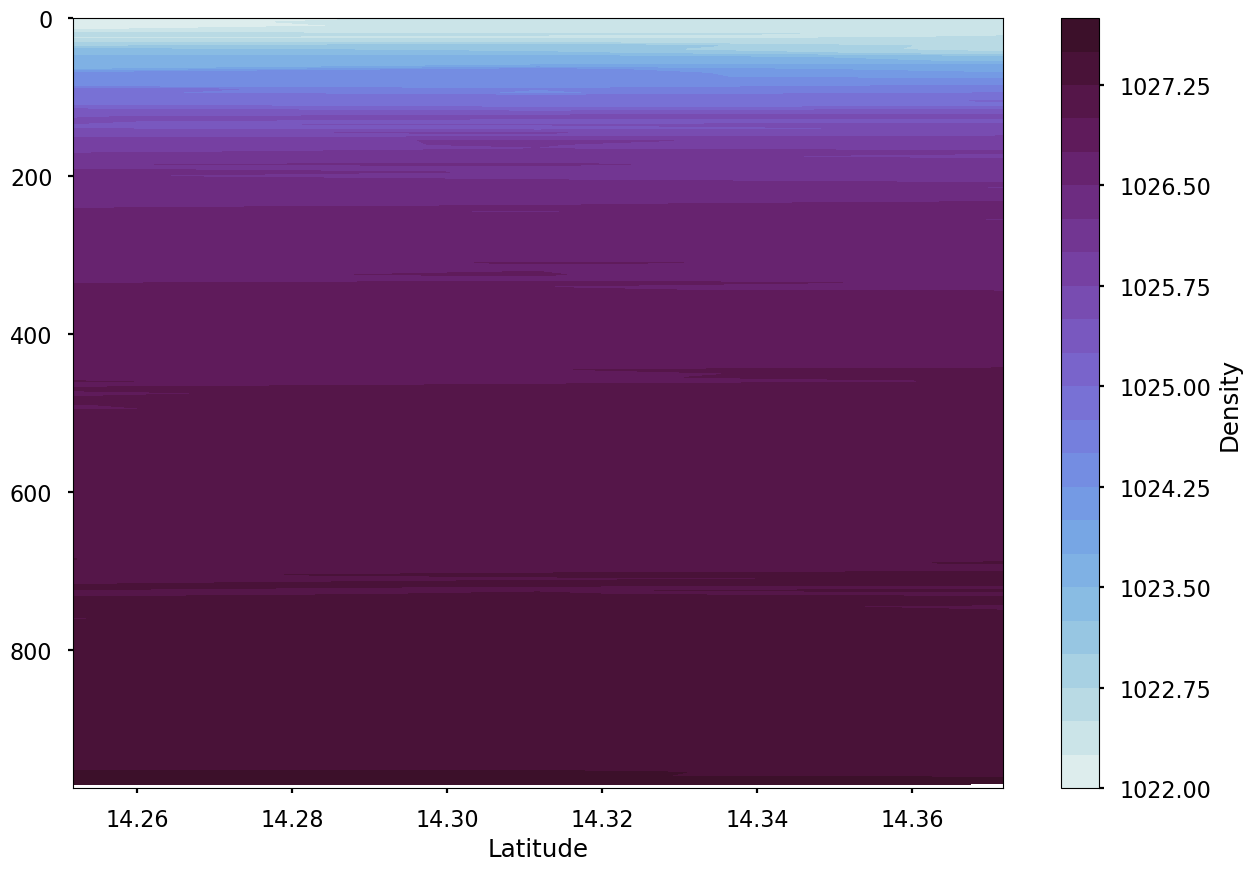

In [40]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df1.latitude,stluc_df1.depth,stluc_df1.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

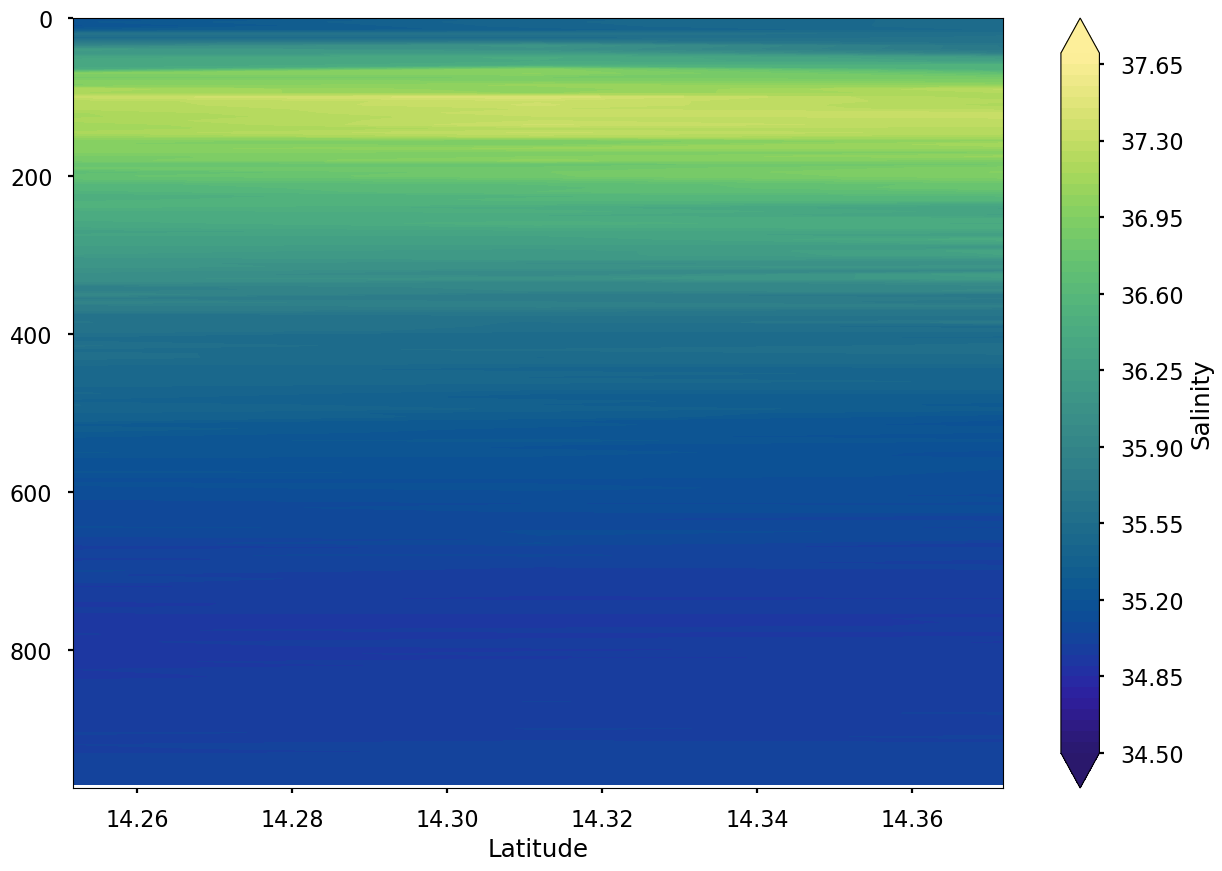

In [41]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df1.latitude,stluc_df1.depth,stluc_df1.salinity,cmap=cmo.haline,levels=np.arange(34.5,37.75,0.05),extend='both')
plt.gca().invert_yaxis()
plt.colorbar(label='Salinity')
plt.xlabel('Latitude')

## St Lucia #2

In [42]:
stluc_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2023-06-19T12:00:00Z',end_time   = '2023-06-20T20:00:00Z', lat_grid_dy=0.08,geo_dz=5)


save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Lucia_Transect_2_2023.nc'

stluc_df2.to_netcdf(save_name)


stluc_df2


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.u[np.abs(subset_df.u) > 5] = np.nan
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80017/3112222332.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

<xarray.Dataset>
Dimensions:      (depth: 196, latitude: 2)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 950 955 960 965 970 975
  * latitude     (latitude) float64 14.27 14.35
    start_time   datetime64[ns] 2023-06-19T09:01:29.550000
    end_time     datetime64[ns] 2023-06-20T18:58:19.590000
    mid_time     datetime64[ns] 2023-06-20T01:59:54.570000
Data variables:
    Vgeo         (depth, latitude) float64 -0.07776 0.1561 ... -0.1171 0.1168
    VgeoEW       (depth, latitude) float64 -0.07102 0.1426 ... -0.1069 0.1067
    density      (depth, latitude) float64 1.022e+03 1.022e+03 ... 1.027e+03
    temperature  (depth, latitude) float64 29.11 28.97 29.02 ... 5.16 5.446
    salinity     (depth, latitude) float64 34.97 34.9 34.96 ... 35.04 34.99
    oxygen       (depth, latitude) float64 nan nan nan nan ... nan nan nan nan
    mean_du      (latitude) float64 -0.2339 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.01112300892338
    max_lon:        -60.96604100365611
    mean_lon:       -60.989411441072406
    geo_dz:         5
    dy:             7141.608864137247
    transect_dist:  21424.82659241174

Text(0.5, 0, 'Latitude')

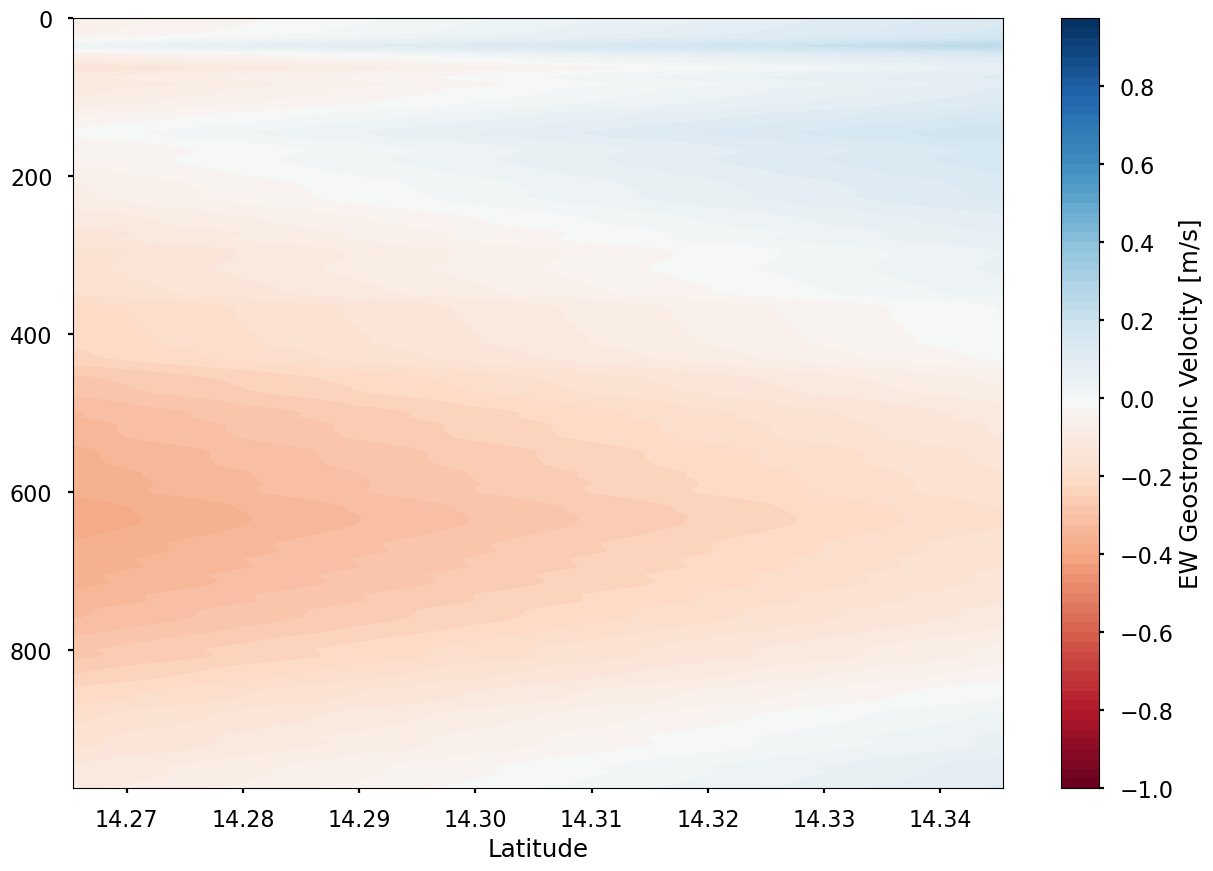

In [43]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df2.latitude,stluc_df2.depth,stluc_df2.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

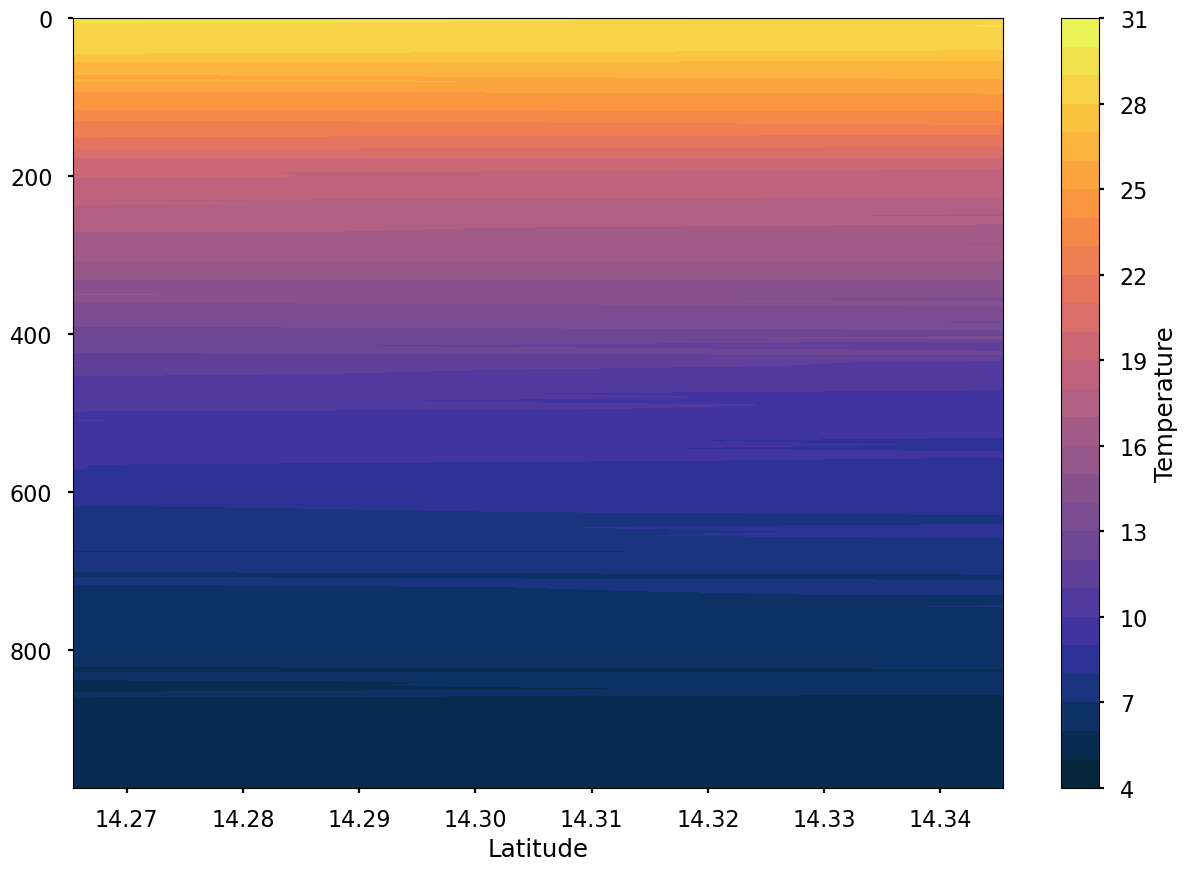

In [44]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df2.latitude,stluc_df2.depth,stluc_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

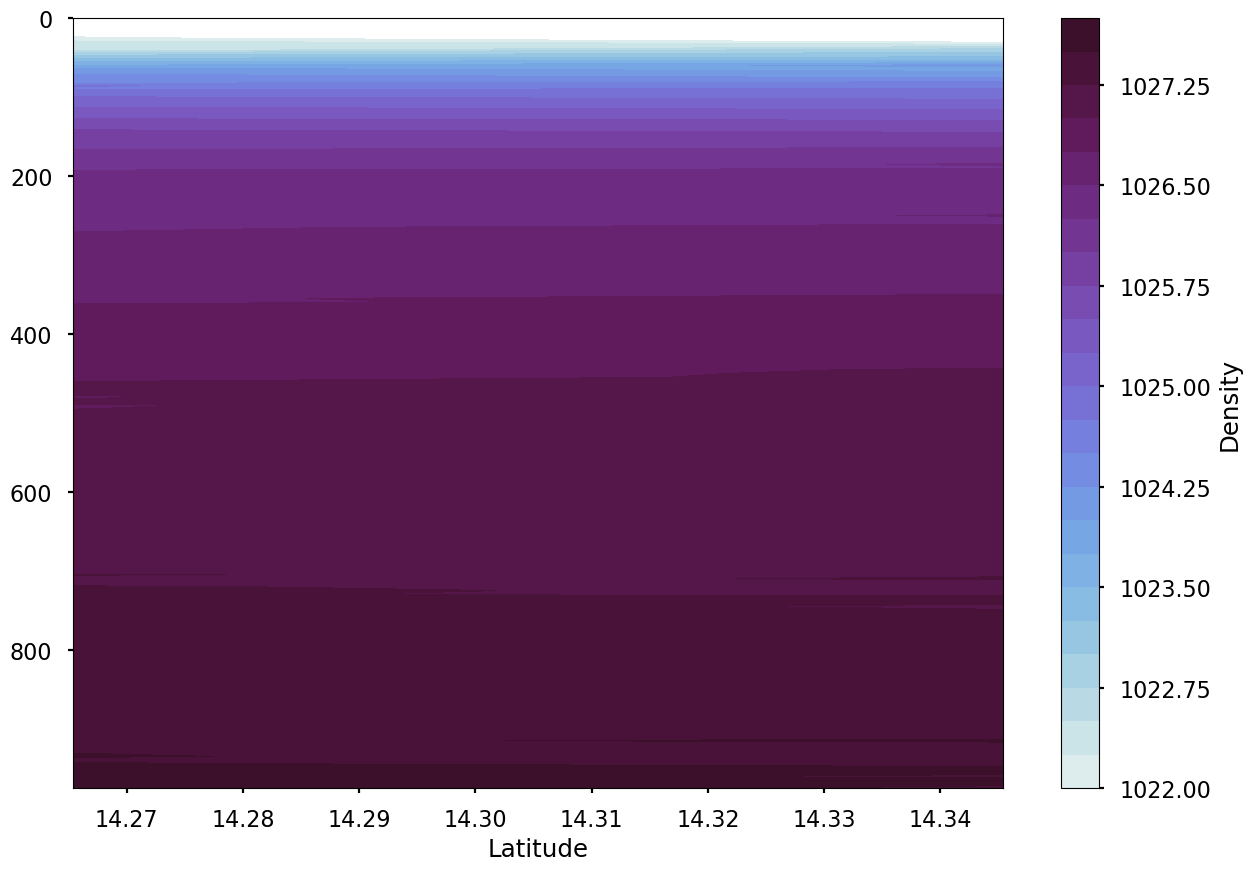

In [45]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df2.latitude,stluc_df2.depth,stluc_df2.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

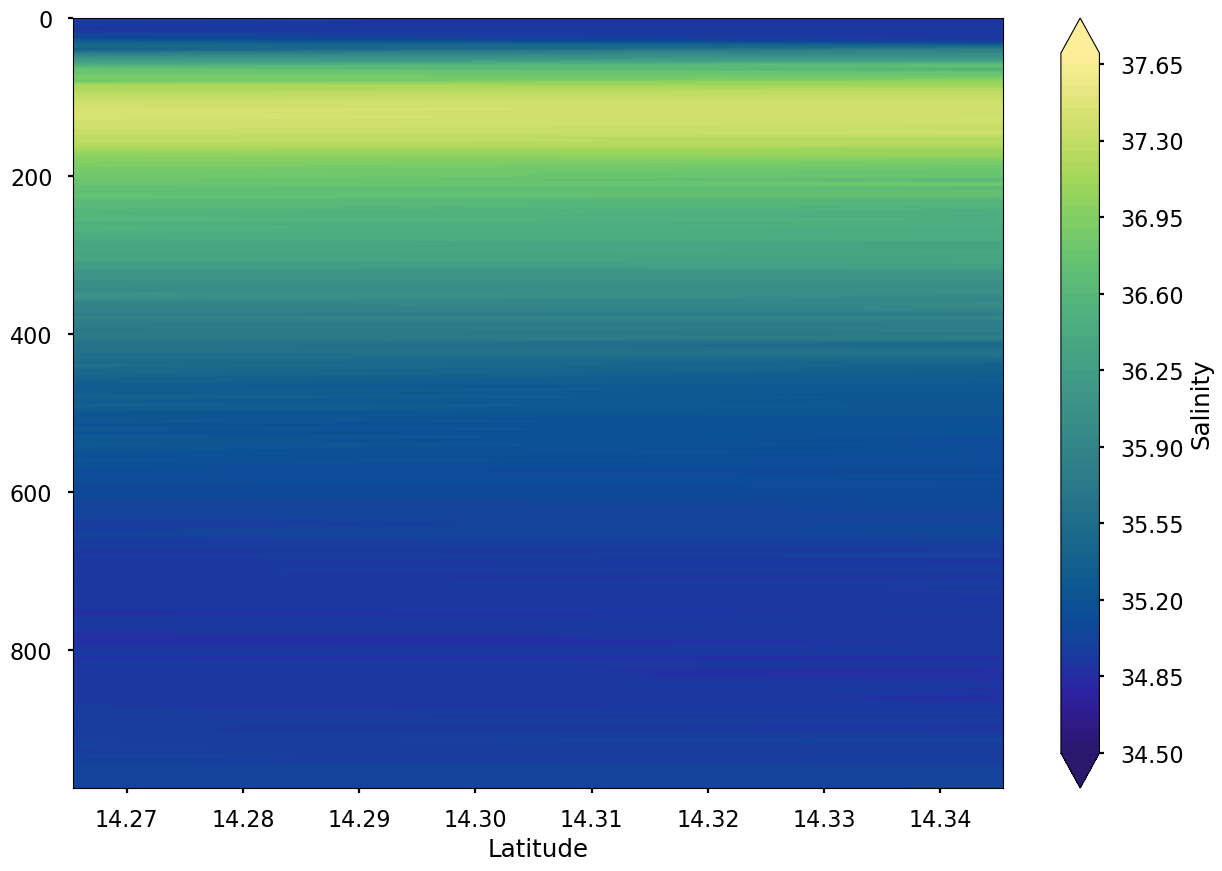

In [46]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df2.latitude,stluc_df2.depth,stluc_df2.salinity,cmap=cmo.haline,levels=np.arange(34.5,37.75,0.05),extend='both')
plt.gca().invert_yaxis()
plt.colorbar(label='Salinity')
plt.xlabel('Latitude')

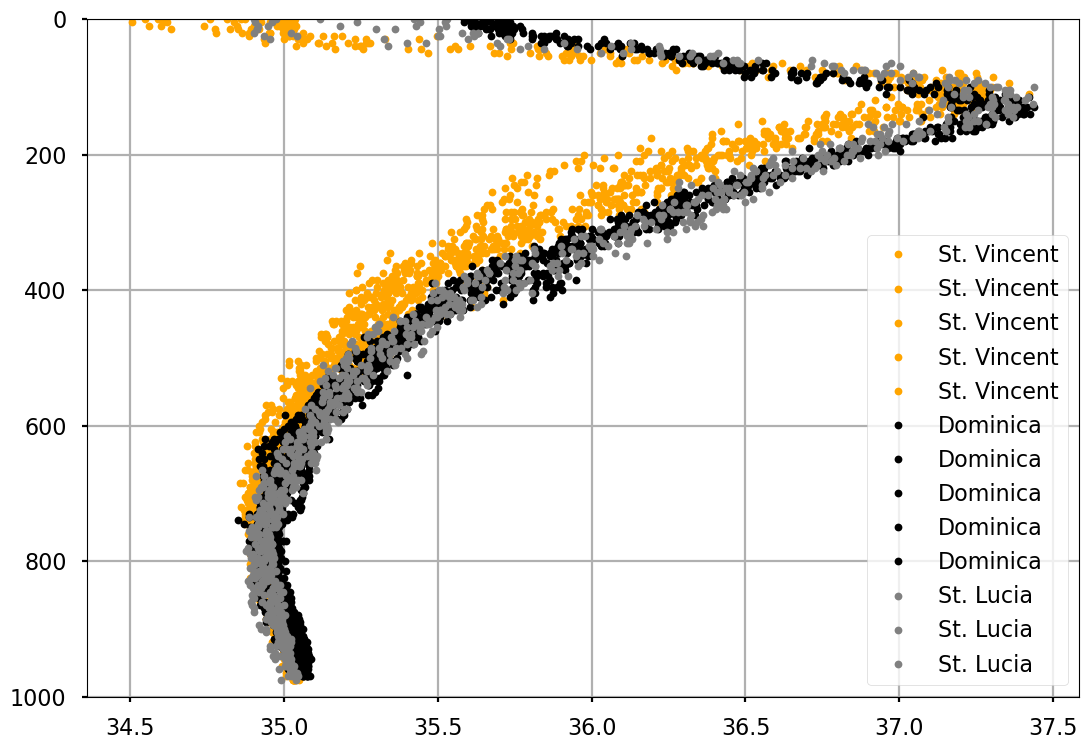

In [70]:

plt.plot(stvin_df1.salinity.values,stvin_df1.depth,'.',color='orange',label='St. Vincent')
plt.plot(stvin_df2.salinity.values,stvin_df2.depth,'.',color='orange')


plt.plot(dominica_df1.salinity.values,dominica_df1.depth,'.',color='black', label='Dominica')
plt.plot(dominica_df2.salinity.values,dominica_df2.depth,'.',color='black')

plt.plot(stluc_df1.salinity.values,stluc_df1.depth,'.',color='grey',label='St. Lucia')
plt.plot(stluc_df2.salinity.values,stluc_df2.depth,'.',color='grey')


plt.ylim(1000,0)
plt.legend()
plt.grid()

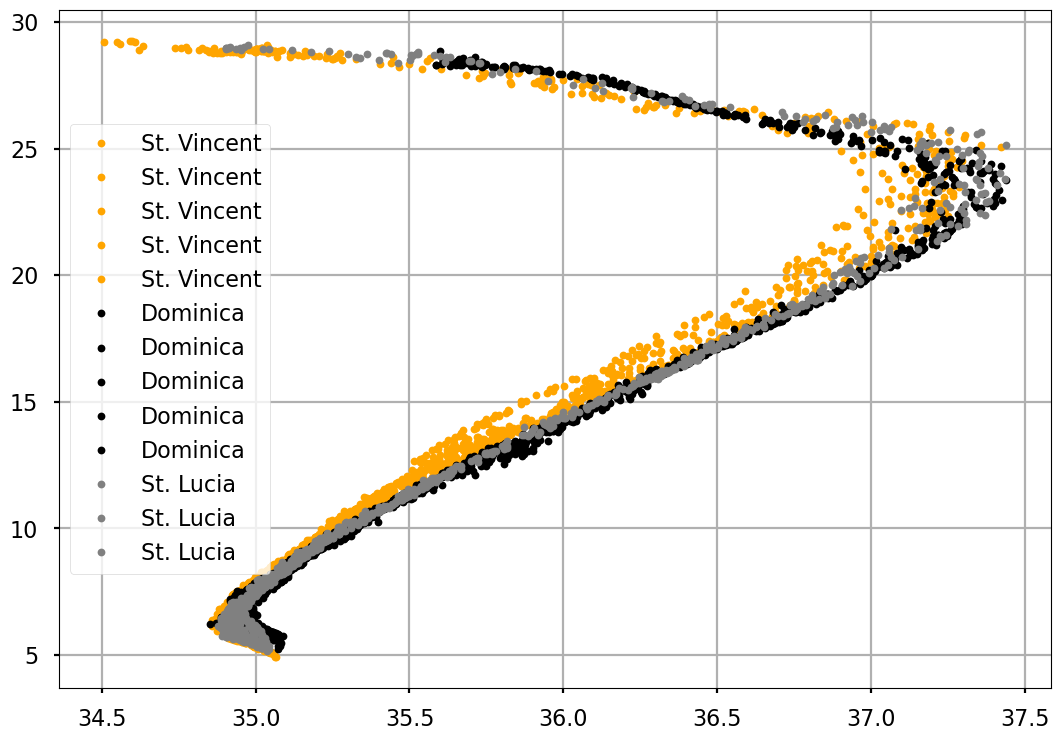

In [71]:

plt.plot(stvin_df1.salinity.values,stvin_df1.temperature,'.',color='orange',label='St. Vincent')
plt.plot(stvin_df2.salinity.values,stvin_df2.temperature,'.',color='orange')


plt.plot(dominica_df1.salinity.values,dominica_df1.temperature,'.',color='black', label='Dominica')
plt.plot(dominica_df2.salinity.values,dominica_df2.temperature,'.',color='black')

plt.plot(stluc_df1.salinity.values,stluc_df1.temperature,'.',color='grey',label='St. Lucia')
plt.plot(stluc_df2.salinity.values,stluc_df2.temperature,'.',color='grey')


#plt.ylim(1000,0)
plt.legend()
plt.grid()

In [47]:
dom_trans_1 = np.nansum(dominica_df1.VgeoEW.values*dominica_df1.attrs['geo_dz']*dominica_df1.attrs['dy'])/(10**6)
dom_trans_1

-2.673416384237417

In [48]:
dom_trans_2 = np.nansum(dominica_df2.VgeoEW.values*dominica_df2.attrs['geo_dz']*dominica_df2.attrs['dy'])/(10**6)
dom_trans_2

-1.9352147998619729

In [49]:
stluc_trans_1 = np.nansum(stluc_df1.VgeoEW.values*stluc_df1.attrs['geo_dz']*stluc_df1.attrs['dy'])/(10**6)
stluc_trans_1

-0.0066415612399298475

In [50]:
stluc_trans_2 = np.nansum(stluc_df2.VgeoEW.values*stluc_df2.attrs['geo_dz']*stluc_df2.attrs['dy'])/(10**6)
stluc_trans_2

-1.494852388106244

In [51]:
stvin_trans_1 = np.nansum(stvin_df1.VgeoEW.values*stvin_df1.attrs['geo_dz']*stvin_df1.attrs['dy'])/(10**6)
stvin_trans_1

-1.3693331462219687

In [52]:
stvin_trans_2 = np.nansum(stvin_df2.VgeoEW.values*stvin_df2.attrs['geo_dz']*stvin_df2.attrs['dy'])/(10**6)
stvin_trans_2

-1.0916590133041801

In [53]:
np.mean([dom_trans_1,dom_trans_2])

-2.304315592049695

In [54]:
np.std([dom_trans_1,dom_trans_2])

0.36910079218772207

In [55]:
np.mean([stluc_trans_1,stluc_trans_2])

-0.7507469746730869

In [56]:
np.std([stluc_trans_1,stluc_trans_2])

0.7441054134331571

In [57]:
np.mean([stvin_trans_1,stvin_trans_2])

-1.2304960797630744

In [58]:
np.std([stvin_trans_1,stvin_trans_2])

0.13883706645889426

## Summary of Transports

| Passage | Johns et al. (2002) | RU29 |
| --- | --- | --- |
| Dominica | 1.6 ± 1.2 Sv | 1.59 ± 0.1 Sv  |
| St. Lucia | 1.5 ± 2.4 Sv | 1.18 ± 0.3 Sv  |
| St. Vincent | 2.9 ± 2.2 Sv | 1.36 ± 0.1 Sv  |